# Network Tour of Data Science - Project: "What impacts the success of a movie?"#
### By Célia Raposo, Yong Joon Thoo, Valentin Kindschi####


$\textbf{Goal of the project:}$ From the start of the declaration of a new film, film companies try to build up hype for their future movie to gain attention. However, gaining much hype or having many page views does not necessarily give a good
indication of the success of a film. Indeed, in recent years, multiple movies have crashed at the box office
despite having reasonably well known actors and a big budget [1]. The goal of this project is to be able to
determine what has the most impact on the success of a movie and possibly evaluate the eventual success of an upcoming film based on multiple features such as its cast or its genre by comparing them to the features of past successful or non
successful films in IMDb [2] (Internet Movie Data Base).



In [ ]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from collections import OrderedDict
from pygsp import graphs, filters, plotting
from IPython.display import Image

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

## 1. Data acquisition and cleaning ##

Datasets [3] obtained from kaggle.com: https://www.kaggle.com/stephanerappeneau/350-000-movies-from-themoviedborg were used, containing different features about the same movie such as its cast, budget, genre, IMDd’s rating, writers, popularity, gross, etc. They also provided each movie’s id which can be used to find it in either IMDb [2] and TMDb [4] to find additional information. Data on theses datasets come from The Movie Databaset (TMDb) which is based on crowdsourcing. 


There was one dataset containing information about the movies such as the realease date, the budget,etc...and an other one containing information about the casting of the movies such as the main actors, the director, the producer, etc... Each of these datasets contained the same number of movies. 

The two inital datasets are the following:

In [2]:
all_movies = pd.read_excel('350000-movies/AllMoviesDetailsCleaned.xlsx',sep=';', encoding='utf-8', 
                           error_bad_lines=False)

In [3]:
all_actors = pd.read_excel('350000-movies/AllMoviesCastingRaw.xlsx',sep=';', encoding='utf-8',
                           error_bad_lines=False)

In [4]:
all_movies.head(4)

id   budget                 genres    imdb_id original_language  \
0   2        0            Drama|Crime  tt0094675                fi   
1   3        0           Drama|Comedy  tt0092149                fi   
2   5  4000000           Crime|Comedy  tt0113101                en   
3   6        0  Action|Thriller|Crime  tt0107286                en   

         original_title                                           overview  \
0                 Ariel  Taisto Kasurinen is a Finnish coal miner whose...   
1  Varjoja paratiisissa  An episode in the life of Nikander, a garbage ...   
2            Four Rooms  It's Ted the Bellhop's first night on the job....   
3        Judgment Night  While racing to a boxing match, Frank, Mike, J...   

  popularity         production_companies      production_countries  \
0   0.823904  Villealfa Filmproduction Oy                   Finland   
1    0.47445  Villealfa Filmproduction Oy                   Finland   
2      1.698                Miramax Films  United States of America   
3    1.32287           Universal Pictures                     Japan   

            ...            runtime  spoken_languages    status  \
0           ...               69.0             suomi  Released   
1           ...               76.0           English  Released   
2           ...               98.0           English  Released   
3           ...              110.0           English  Released   

                                             tagline                title  \
0                                                NaN                Ariel   
1                                                NaN  Shadows in Paradise   
2  Twelve outrageous guests. Four scandalous requ...           Four Rooms   
3     Don't move. Don't whisper. Don't even breathe.       Judgment Night   

  vote_average vote_count  production_companies_number  \
0          7.1         40                            2   
1          7.0         32                            1   
2          6.5        485                            2   
3          6.5         69                            3   

   production_countries_number  spoken_languages_number  
0                            1                        2  
1                            1                        3  
2                            1                        1  
3                            2                        1  

[4 rows x 22 columns]

In [5]:
all_actors.head(4)

id        actor1_name  actor1_gender       actor2_name  actor2_gender  \
0   2        Turo Pajala              0  Susanna Haavisto            0.0   
1   3  Matti PellonpÃ¤Ã¤              2      Kati Outinen            1.0   
2   5           Tim Roth              2  Antonio Banderas            2.0   
3   6     Emilio Estevez              2  Cuba Gooding Jr.            2.0   

         actor3_name  actor3_gender   actor4_name  actor4_gender  \
0  Matti PellonpÃ¤Ã¤              2  Eetu Hilkamo              0   
1   Sakari Kuosmanen              2  Esko Nikkari              2   
2     Jennifer Beals              1       Madonna              1   
3        Denis Leary              2  Jeremy Piven              2   

      actor5_name  actor5_gender  actor_number    director_name  \
0            none              0             4  Aki KaurismÃ¤ki   
1  Kylli KÃ¶ngÃ¤s              0             7  Aki KaurismÃ¤ki   
2    Marisa Tomei              1            24   Allison Anders   
3    Peter Greene              2            15  Stephen Hopkins   

   director_gender  director_number     producer_name  producer_number  \
0              0.0                1              none                0   
1              0.0                1  Mika KaurismÃ¤ki                1   
2              1.0                4   Lawrence Bender                1   
3              2.0                1         Gene Levy                1   

    screeplay_name         editor_name  
0  Aki KaurismÃ¤ki        Raija Talvio  
1  Aki KaurismÃ¤ki        Raija Talvio  
2             none  Margaret Goodspeed  
3     Lewis Colick        Tim Wellburn

In [6]:
print('The initial datasets contain {} movies'.format(len(all_movies)))

The initial datasets contain 329044 movies


The two datasets were then merged and cleaned in order to have one dataset containing only the usefull information.

As can be seen, the dataset includes movies of diverse actors, genres, countries, years, etc. However certain films, notably those produced in non english speaking countries, contain budgets of zero and/or contain missing information. Furthermore, as most of the films produced by these companies are not showed on screens worldwide, they might not have the same impact. Thus, in addition to the films missing information or non relevant features, it was decided to remove all non english movies from our dataset. 

Therefore the merged dataset was cleaned by removing the following movies:
- Movies with revenue equal to zero
- Movies with an original language different from english
- Movies without any genre provided
- Movies with a budget below 1000 dollars (probably errors)
- Movies without a director name
- Movies without any actors
- Movies without a production company name
- Movies that were not released between 1st January 2000 and 31th Decembre 2016 in order to have.... 

Moreover, only relevant columns of the two datasets were kept, which are: the budget, the genre, imdb id, the overview, production companies, release date, revenue, (tagline), title, director name and actor name.

Later on the project, other information were collected:

- Data from metacritic website (http://www.metacritic.com/) thanks to the metacritic API were collected. In Metacritic website, ratings on movies are given by press reviewers before the release of the movie. Then these data were added to the main dataset and movies which were not present in metacritic website were removed from the main dataset.
- In order to get more information on actor such as the tenure of the actors, other data which were not in the inital datset, were collected thanks to the api of the TMDb website.
- The average number of trailer views over 5 different sources on YouTube.

The final, merged dataset is then displayed below:

In [7]:
df = pd.read_csv('Saved_Datasets/CleanDataset.csv')

In [8]:
df.head(4)

id     budget                    genres  imdb_id  \
0  12   94000000          Animation|Family   266543   
1  16   12800000         Drama|Crime|Music   168629   
2  22  140000000  Adventure|Fantasy|Action   325980   
3  24   30000000              Action|Crime   266697   

                                            overview     production_companies  \
0  Nemo, an adventurous young clownfish, is unexp...  Pixar Animation Studios   
1  Selma, a Czech immigrant on the verge of blind...       Fine Line Features   
2  Jack Sparrow, a freewheeling 17th-century pira...     Walt Disney Pictures   
3  An assassin is shot at the altar by her ruthle...            Miramax Films   

  release_date    revenue                                              title  \
0   2003-05-30  940335536                                       Finding Nemo   
1   2000-05-17   40031879                                 Dancer in the Dark   
2   2003-09-07  655011224  Pirates of the Caribbean: The Curse of the Bla...   
3   2003-10-10  180949000                                  Kill Bill: Vol. 1   

       director_name                                        actor_names  \
0     Andrew Stanton  ['Albert Brooks', 'Ellen DeGeneres', 'Alexande...   
1     Lars von Trier  ['Björk', 'Catherine Deneuve', 'David Morse', ...   
2     Gore Verbinski  ['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...   
3  Quentin Tarantino  ['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox', '...   

   Metacritic YouTube_Mean  
0          90        0.218  
1          61        Error  
2          63          1.0  
3          69          1.0

In [9]:
print('The final dataset contains {} movies'.format(len(df)))

The final dataset contains 2621 movies


In [10]:
df = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [11]:
df.head(3)

id     budget                    genres  imdb_id  \
0  12   94000000          Animation|Family   266543   
1  16   12800000         Drama|Crime|Music   168629   
2  22  140000000  Adventure|Fantasy|Action   325980   

                                            overview     production_companies  \
0  Nemo, an adventurous young clownfish, is unexp...  Pixar Animation Studios   
1  Selma, a Czech immigrant on the verge of blind...       Fine Line Features   
2  Jack Sparrow, a freewheeling 17th-century pira...     Walt Disney Pictures   

  release_date    revenue                                              title  \
0   2003-05-30  940335536                                       Finding Nemo   
1   2000-05-17   40031879                                 Dancer in the Dark   
2   2003-09-07  655011224  Pirates of the Caribbean: The Curse of the Bla...   

    director_name   ...                    actors_ids        actors_tenures  \
0  Andrew Stanton   ...        [14, 5293, 12, 13, 18]   [18, 24, 2, 28, 14]   
1  Lars von Trier   ...        [6748, 47, 52, 50, 53]  [49, 19, 21, 44, 15]   
2  Gore Verbinski   ...     [1709, 116, 114, 118, 85]     [7, 9, 7, 22, 20]   

  total_tenure  average_tenure  Total_profitability_actors  Metacritic  \
0           86            17.2                  7310194071          90   
1          148            29.6                   294261790          61   
2           65            13.0                 15077223101          63   

   YouTube_Mean Profitability    ROI  success  
0         0.218     846335536  2.639        1  
1         Error      27231879  2.127        1  
2           1.0     515011224  2.639        1  

[3 rows x 21 columns]

## 2. Data exploration ##

The goal of the project is to identify which parameters impact the success of a movie and if possible, to try and predict the success of a movie before its release. A lot of features can be constructed and explored. Indeed, whereas some features are more about the movie itself such as the cast or the genre of the movie, others are more about its popularity and network effect such as the Metacritic reviews and the number of views of the trailer. 

After cleaning our dataset, multiple aspects of the features were therefore explored to give us more information about our dataset as well as to give us an indication of how we would later be able to exploit our data to reach our goal.


In this work, the following features were studied and explored:
* The measure of succes determined by the Return on investment 
* Genres similarities between movies
* Actor similarities between movies
* Actors tenures at the released date of the movie
* Similarity between profitability of actors between pairs of movies
* Director similarties between movies
* Similarities between number of movies per director
* Similarities between number of movies per production company
* Production companies similarities between movies
* Storyline analysis
* Metractric grades similarities between movies
* Budget difference between movies
* Number of view on trailers on YouTube before the realease date of movies


### 2.1. Success Definition

We have access to two metrics to define if a movie is successful or not: the metacritic and the revenue. The former is a qualitative measurement representing the overall quality of a movie and the latter a quantitative number that shows if a movie "worked" or not.

We decided to focus on the quantitative measurment, because we think that most of the people interseted in knowing if a movie will work want to know if it is going to generate money rather than knowing if it is a masterpiece.

However, to be able to compare movies, we need a mesurement that takes into account the revenue, but also the budget. This is why we computed the Return On Investment or ROI.

#### 2.1.1 Return On Investment - ROI

The return on investment or ROI, is defined as:
$$ ROI = \frac{revenue-budget}{budget}$$

Hence, when the revenue is smaller than the budget the ROI can be negative. When the ROI is null, the movie reached the break-even point, where the revenue is equal to the budget.

We also saturated the data above the third quartile, i.e. 75%, to avoid having a large spread and and beacuse we noticed that most of the very high ROI were in fact due to mistakes in the dataset (very high revenue or very low budget for example)

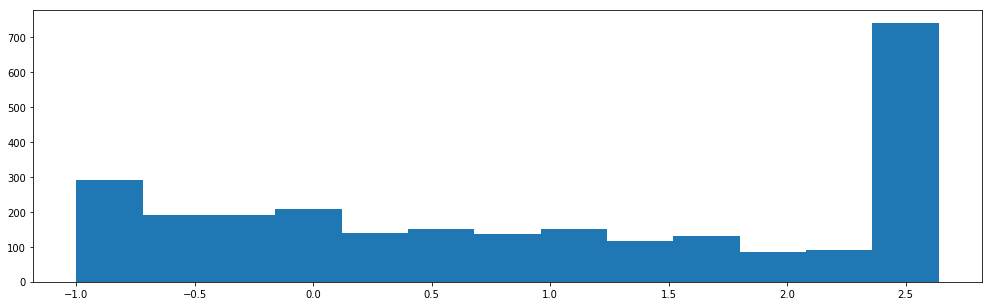

In [12]:
plt.hist(df['ROI'],bins='auto');

#### 2.1.2 Regression ####

We determined two ways to evaluate is a movie is successful. The first solution to determine the success of a movie is to keep the ROI values to later perform a regression.

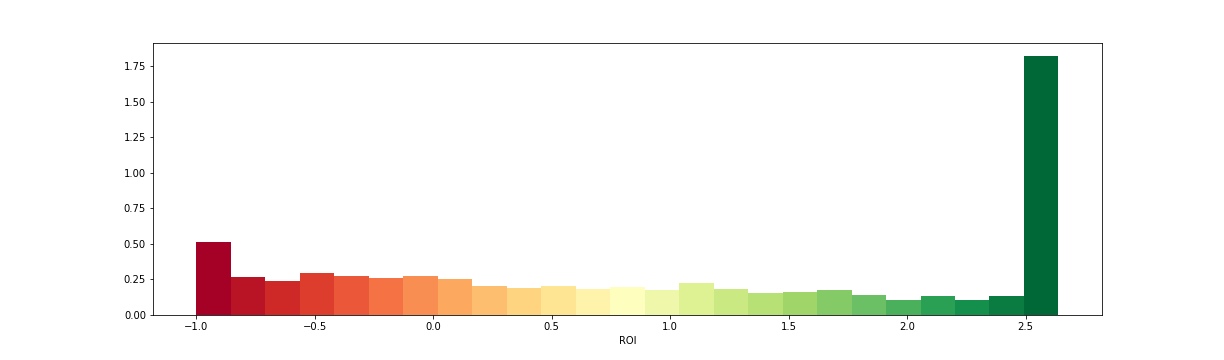

In [13]:
Image("images/ROI_regression.png")

*Note that the figure seems to have a discrete number of ROI values, which is not the case in our regression algorithm.*

#### 2.1.3 Classification

The second way to evaluate the success is to divide the ROI into two categories: success and failure. We decided to consider the lowest 25% ROI as failure and the upper 75% ROI as success.

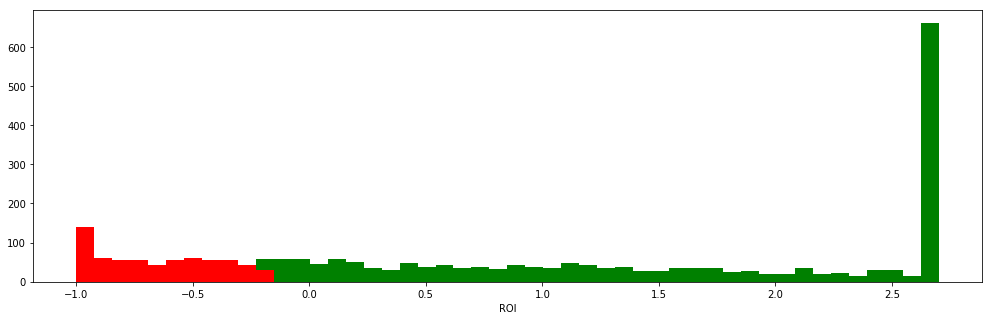

In [14]:
colors = ['red','green']
plt.hist([df[df['success']==0]['ROI'], df[df['success']==1]['ROI']],bins='auto',color=colors,stacked=True,range=(-1,2.7));
plt.xlabel('ROI');

The peak with a green ROI is because of the saturation. 

### 2.2 Budget ###

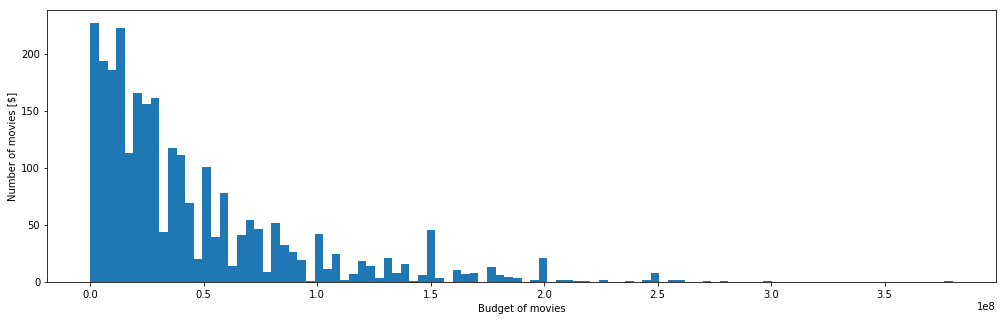

In [15]:
plt.hist(df['budget'],bins=100);
plt.xlabel('Budget of movies')
plt.ylabel('Number of movies [$]')
plt.savefig('images/movies_budget.png', dpi=300, bbox_inches='tight')

In the distribution of budget of movies in the dataset, it can be seen that a lot of movies has a budget comprising between 1000 and 100'000'000'. 

In [16]:
print('The average budget of movies in the dataset is {} $'.format(df['budget'].mean()))

The average budget of movies in the dataset is 44398899.01907669 $


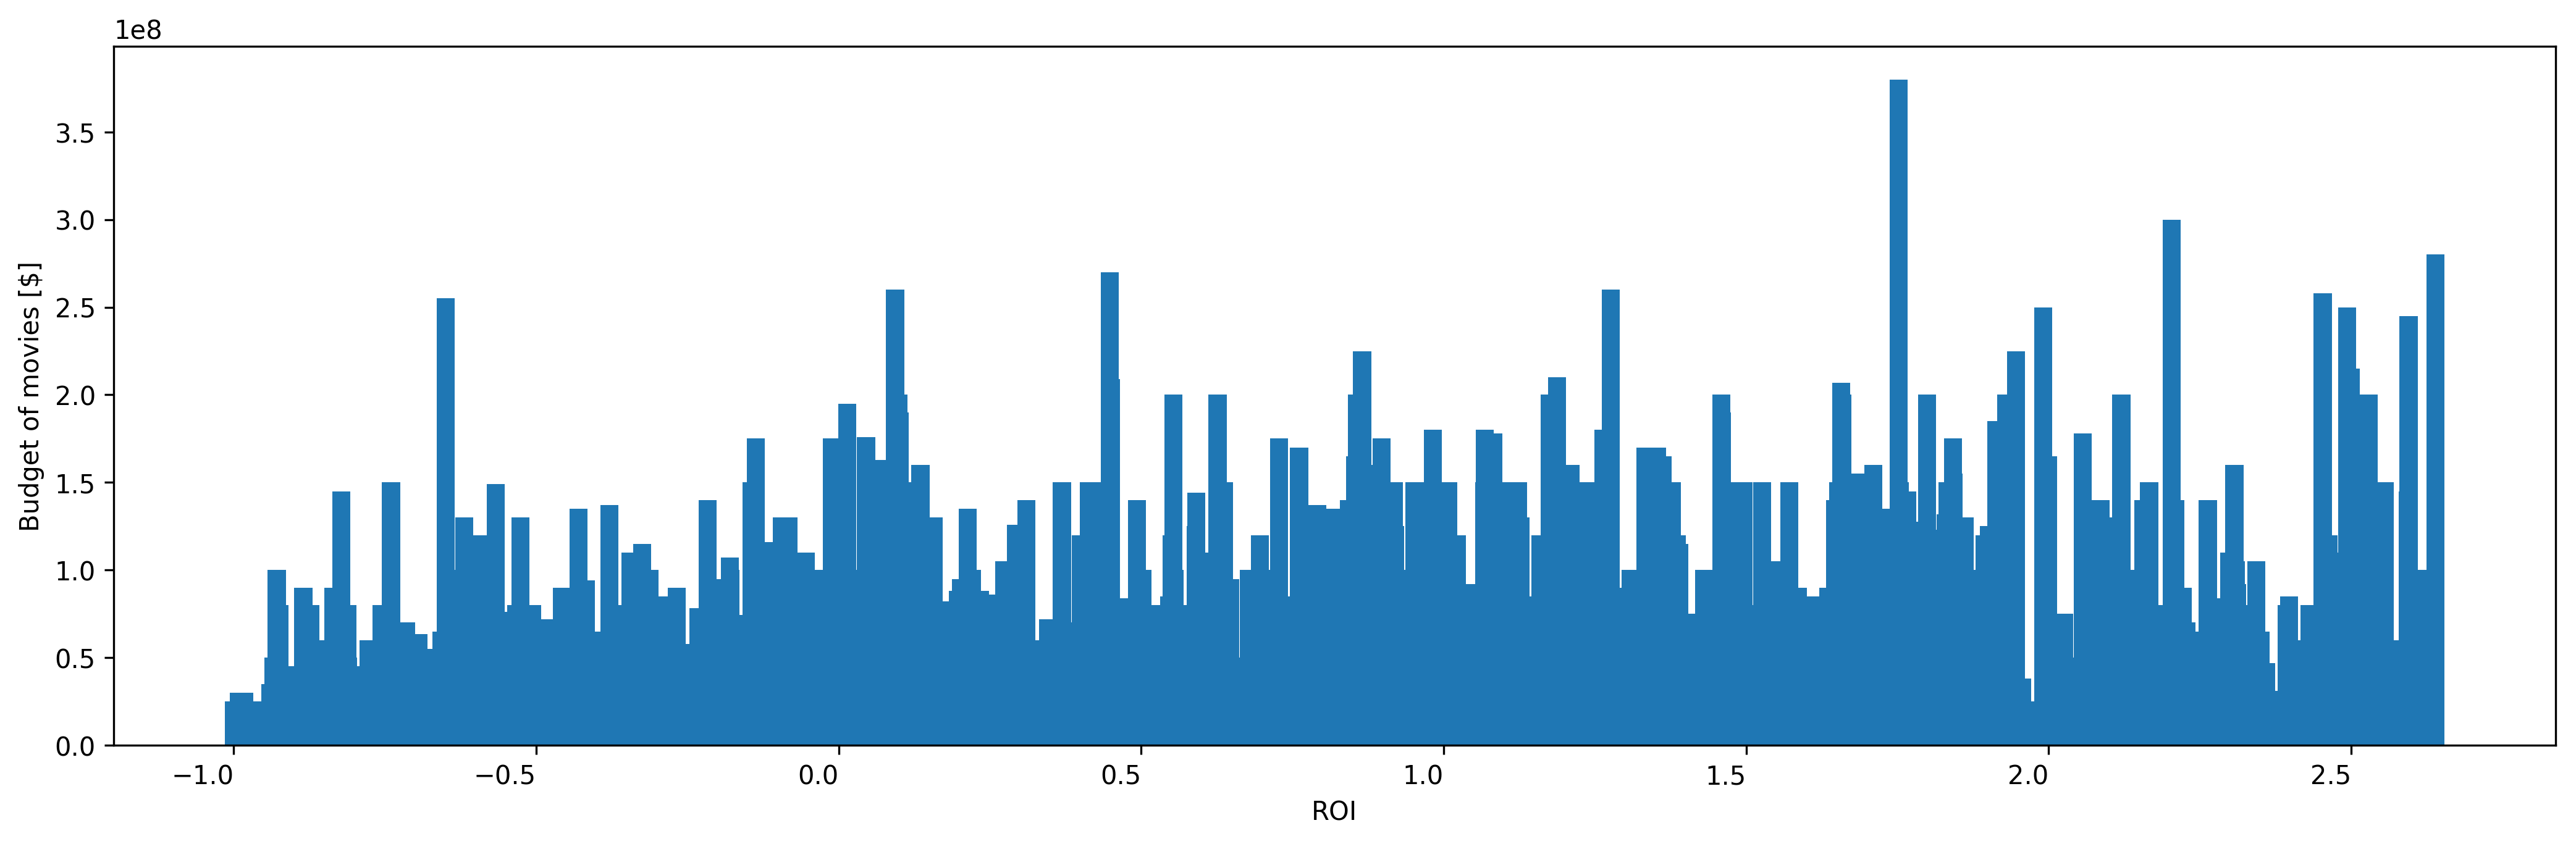

In [17]:
Image("images/budget_ROI.png")

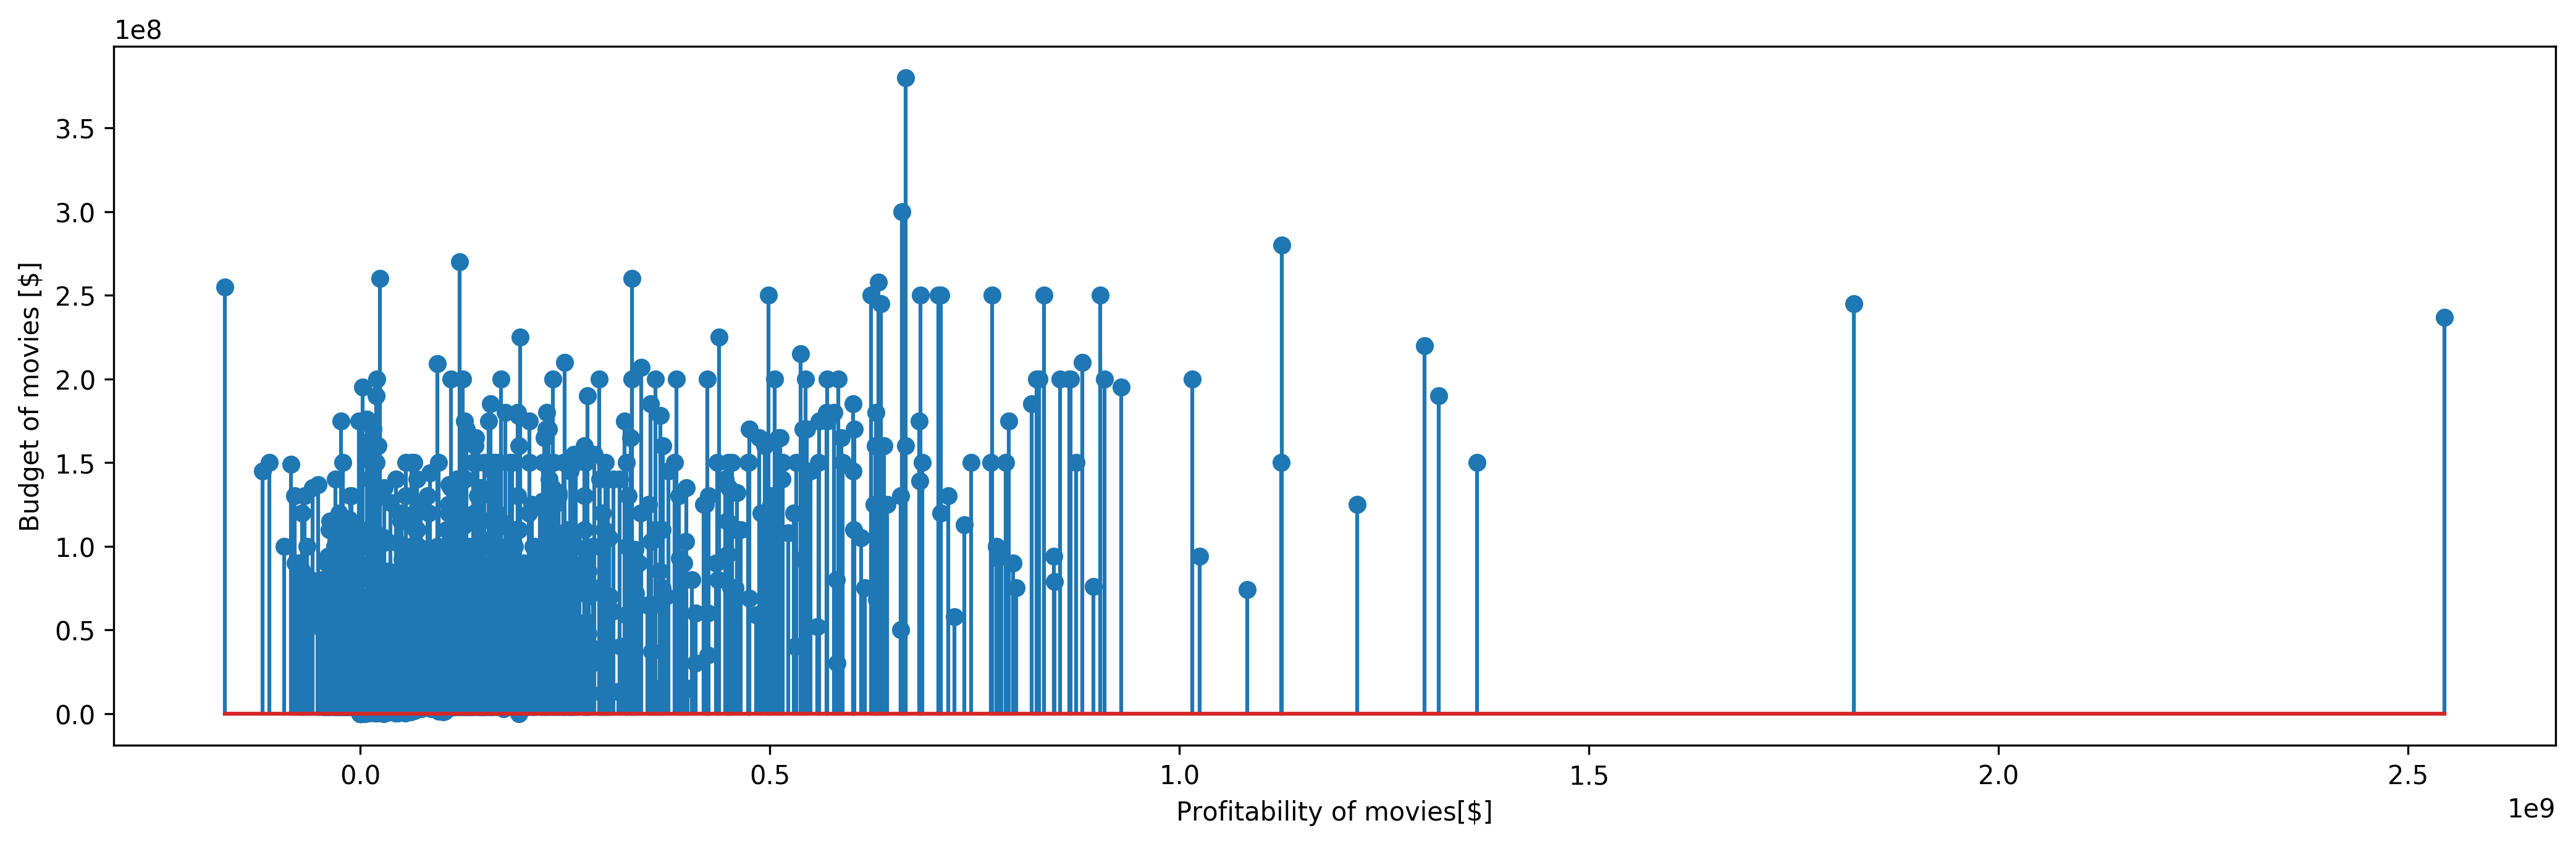

In [18]:
Image("images/budget_Profitability.png")

By observing the distribution of budget as function of the ROI and as function of the profitability of movies, there is no correlation between the budget of movies and the ROI and the profitability.
To note that the ROI of movies in the dataset has been saturated to 2.64 

### 2.3. Genres ### 

In this section, we want to explore the movies based on the genre, such as how many films are there per genre, to which other genres are they most often associated and does one genre seem to be most successful than another.

#### 2.3.1. Number of films per genre ####

In this subsection, we are interested in knowing which genres are most present in our dataset. To do this, we simply compute the number of times a movie indicates a certain genre. The results are then shown below.

$\underline{\textbf{Note:}}$ Since some movies have multiple genres, the sum of the number of movies per genre exceeds the total number of movies in our dataset

In [19]:
GenreFreq = pd.read_csv('Saved_Datasets/NbGenre.csv')

In [20]:
GenreFreq

TV Movie  War  Music  Drama  Thriller  Western  Comedy  Foreign  Crime  \
0         1   74     81   1212       785       26     910        6    419   

   Mystery  Horror  History  Adventure  Animation  Action  Romance  Fantasy  \
0      230     278       88        491        160     684      457      261   

   Science Fiction  Family  Documentary  
0              297     293           36

These results can also be visualized in the histogram plot below:

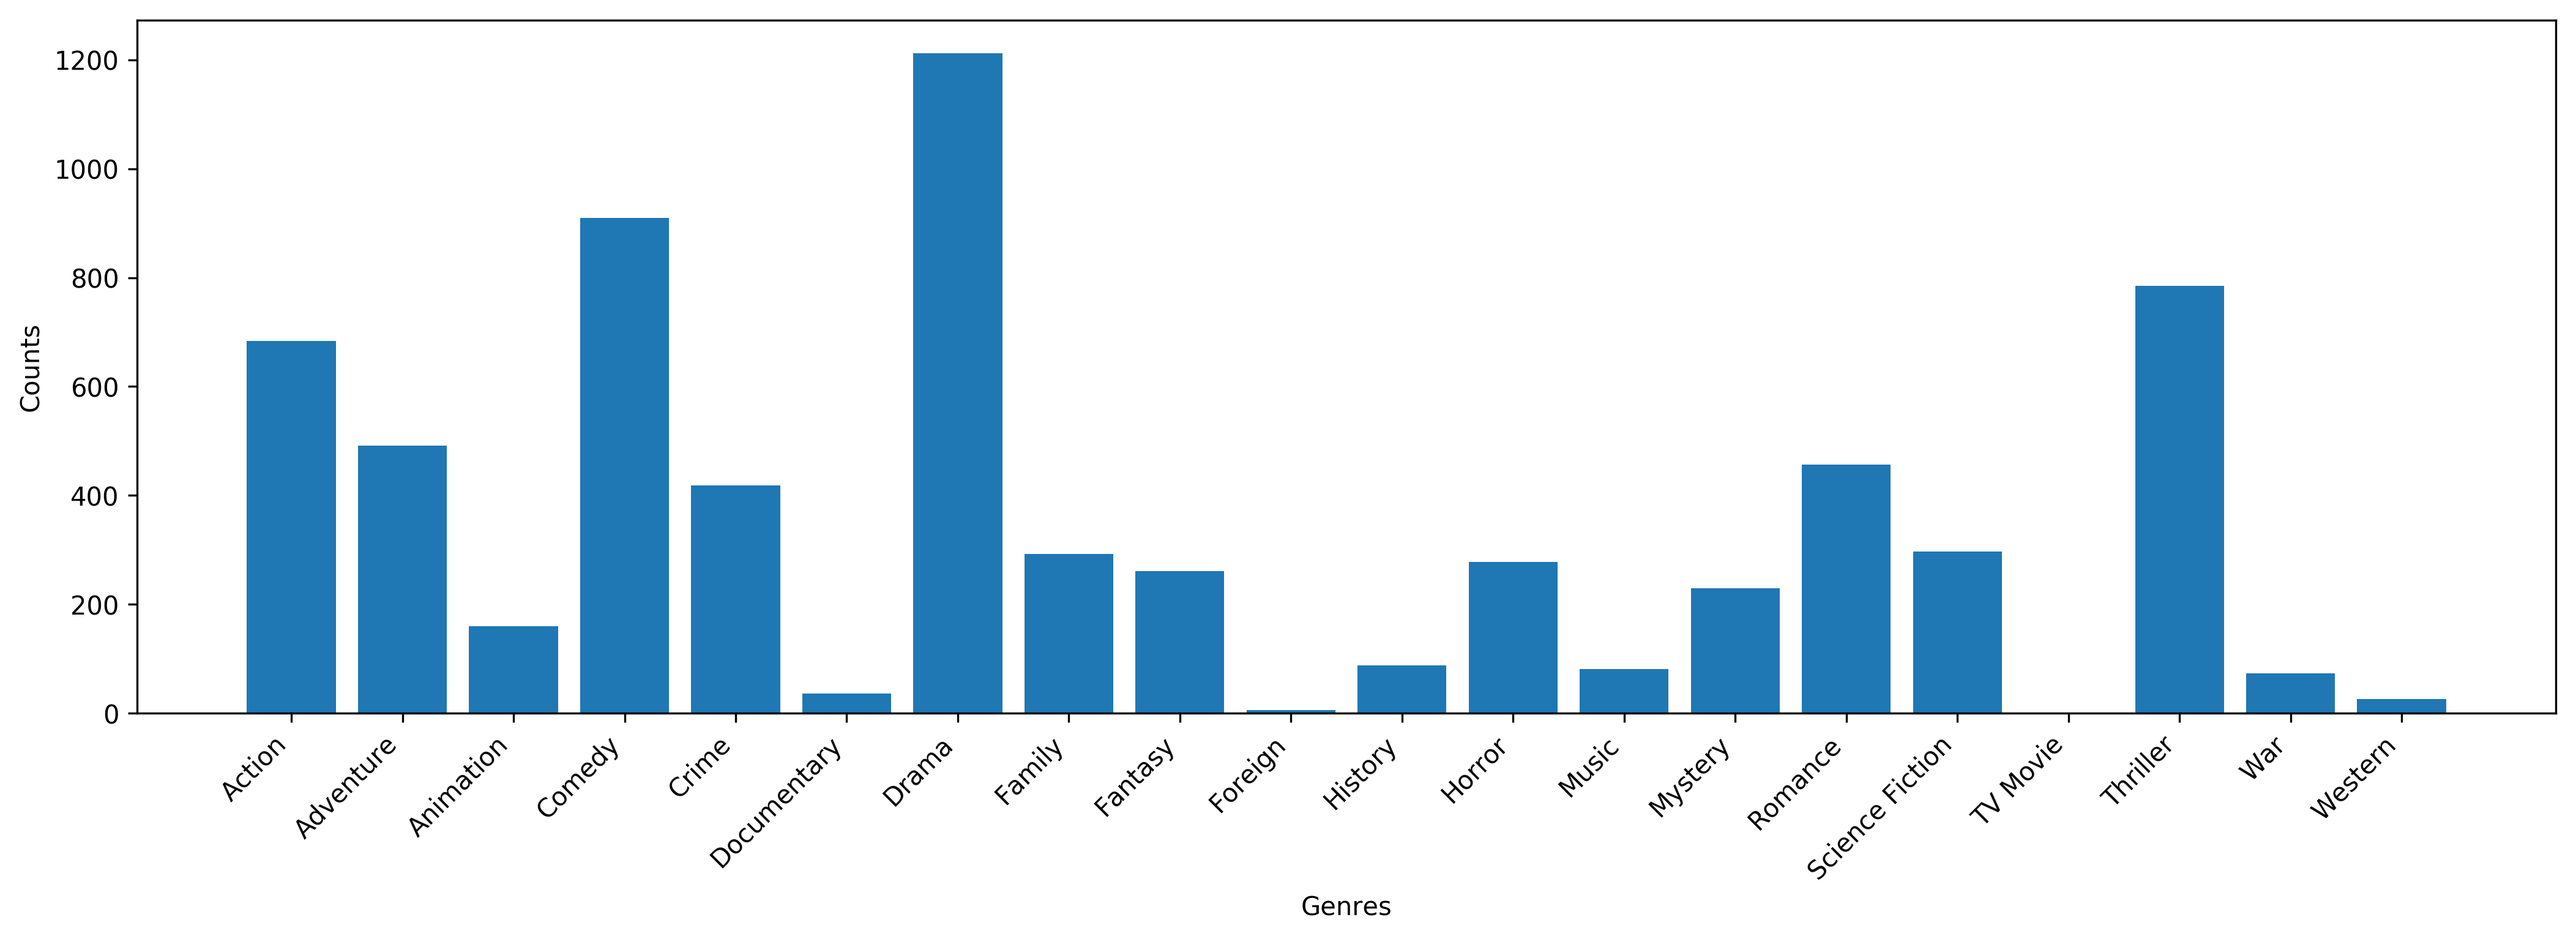

In [21]:
Image("images/GenreFreq.png")

From this plot, we can observe that there is a big difference between the number of movies per genre! Indeed, we can typically see that there are few foreign or TV movies compared to the number of drama or comedy movies. However, as this calculation is only done on the number of films in our cleaned dataset, this is not representative of the number of films per genre in reality.  

#### 2.3.2. Rate success per genre ####

Knowing the labels of each film (success or not) defined in the previous section, we can then try to determine whether a certain genre tends to be more successful than another. To do this, we simply divide the number of films of a certain genre which are labeled as successful and we divide it by the total number of films of this genre.

The results are then shown in the figure below:

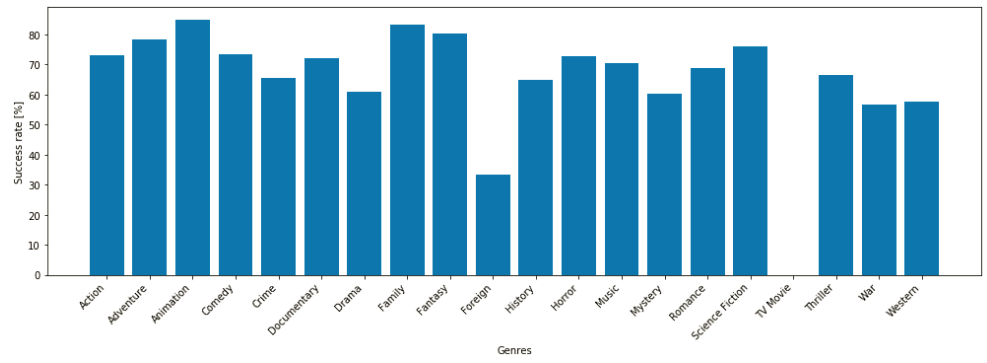

In [22]:
Image("images/GenreSuccessRate.PNG")

As mentionned above, our computations are based only on the movies contained in our dataset and our definition of success. As such, we can see that for the genre "TV Movie" of which we only have one movie, the success rate is zero. This therefore does not give us a good generalization of the success rate in reality. 

Furthermore, as indicated previously, our dataset seems to contain much more successful films than uncessful which could influence the computation as a lot of unsuccessful english films could have been removed in our data cleaning due to missing data. 

#### 2.3.3. Genre associations ####

Another interesting thing that could be determined is the genres with which each genre is most commonly associated. This was done by counting the number of times each pairs of genres appear with each other and then by sorting them by descending order. 

The result is then shown in the dataframe below where 0 indicates the most frequent and 18 indicates the least frequent.

In [23]:
GenreRanking = pd.read_csv('Saved_Datasets/GenreRanking.csv')

In [24]:
GenreRanking

Action        Adventure        Animation           Comedy  \
0          Thriller           Action           Family            Drama   
1         Adventure           Family           Comedy          Romance   
2             Crime           Comedy        Adventure           Family   
3             Drama          Fantasy          Fantasy           Action   
4   Science Fiction  Science Fiction           Action        Adventure   
5            Comedy         Thriller  Science Fiction        Animation   
6           Fantasy            Drama            Music            Crime   
7            Horror        Animation            Drama          Fantasy   
8           Mystery          Romance         Thriller         Thriller   
9            Family            Crime          Romance  Science Fiction   
10              War          Mystery          Western            Music   
11          Romance              War          Mystery           Horror   
12        Animation          Western              War          Mystery   
13          History          History            Crime      Documentary   
14          Western           Horror         TV Movie          Western   
15            Music            Music          History              War   
16      Documentary      Documentary           Horror          History   
17          Foreign          Foreign          Foreign          Foreign   
18         TV Movie         TV Movie      Documentary         TV Movie   

              Crime      Documentary            Drama           Family  \
0          Thriller            Music         Thriller           Comedy   
1             Drama           Comedy          Romance        Adventure   
2            Action           Family           Comedy        Animation   
3            Comedy            Drama            Crime          Fantasy   
4           Mystery          Foreign           Action           Action   
5         Adventure           Action          Mystery            Drama   
6            Horror        Adventure        Adventure  Science Fiction   
7           Romance         TV Movie          History          Romance   
8   Science Fiction  Science Fiction  Science Fiction            Music   
9           History          Fantasy              War         Thriller   
10          Fantasy          Romance          Fantasy          Mystery   
11          Western        Animation           Horror      Documentary   
12            Music          Mystery            Music            Crime   
13              War           Horror           Family          Western   
14          Foreign            Crime          Western           Horror   
15           Family          Western        Animation          Foreign   
16         TV Movie         Thriller          Foreign              War   
17        Animation              War      Documentary          History   
18      Documentary          History         TV Movie         TV Movie   

            Fantasy          Foreign          History           Horror  \
0         Adventure            Drama            Drama         Thriller   
1            Action      Documentary              War          Mystery   
2            Family            Crime           Action            Drama   
3            Comedy         Thriller         Thriller           Action   
4             Drama           Comedy        Adventure  Science Fiction   
5   Science Fiction           Action          Romance          Fantasy   
6          Thriller           Family            Crime           Comedy   
7           Romance           Horror           Comedy            Crime   
8         Animation  Science Fiction          Mystery        Adventure   
9            Horror          Fantasy          Western          Romance   
10          Mystery          Romance  Science Fiction              War   
11            Music        Animation          Fantasy            Music   
12            Crime         TV Movie        Animation          Foreign   
13             

Due to the same reasons listed above, we can see that "TV Movies" often figures amongst the least commonly associated genre. Furthermore, due to the limited size of our dataset, there are certain genres that are never associated to multiple other genres. As such, the ranking between the genres that have 0 associations with this genre would no longer make sense.

$\textbf{For example:}$ If genre i is never associated to genres j, k, l. It is impossible to determine a ranking between them for genre i.

However, as can be seen in the association matrix below (where associated genres are indicated in black), the minimum number of associations is 3 (see the first line). This means that for all genres, the top 3 results are representative certain trends in our cleaned dataset. 

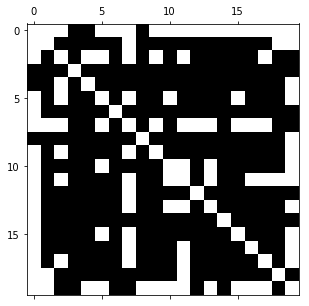

In [25]:
NbGenreAssos = pd.read_csv('Saved_Datasets/NbGenreAssos.csv')
plt.spy(NbGenreAssos)

### 2.4. Actors ###

####  2.4.1 Data collection and tenures computation ####

As mentionned in section 1, Data were collected with the TMDb API in order to build the following dataset, which contains information about actors who play in movies that are in the main dataset.

In [28]:
Actors = pd.read_csv('Saved_Datasets/Actorsv4Dataset.csv')

In [29]:
Actors.head(4)

tmdb_id            Name              date  total_tenure  nb_total_movies  \
0    15295  Vicky Haughton  ['2000', '2010']            11                5   
1    16940    Jeremy Irons  ['1974', '2016']            43               90   
2    41087     Leslie Mann  ['1996', '2016']            21               31   
3    52262    Sean Maguire  ['2000', '2015']            16                7   

                                   movies_in_dataset  \
0                                    ['Whale Rider']   
1  ['Kingdom of Heaven', 'Eragon', 'Dungeons & Dr...   
2  ['Knocked Up', 'I Love You Phillip Morris', '1...   
3                              ['Meet the Spartans']   

                  Realease_date_of_movies_in_dataset  \
0                                           ['2003']   
1  ['2005', '2006', '2000', '2008', '2011', '2012...   
2  ['2007', '2009', '2009', '2009', '2011', '2011...   
3                                           ['2008']   

                    Actors_tenure_in_movies  Profitability  
0                                       [4]       33400000  
1      [32, 33, 27, 35, 38, 39, 40, 43, 43]      369419665  
2  [12, 14, 14, 14, 16, 16, 15, 17, 19, 19]     1314569622  
3                                       [9]       54646831

In this section, the idea is to evaluate the impacts of choice of the actor in a movie on the success of the movie. First the total tenure of each actors was computed. The total tenure of an actor is the time difference in years between the release date of the movie in which he first ever appeared and the last movie in which he has played. Only the movies until 2016 were taken in account.
However, the total tenure is not very relevant because when a specific movie is studied, the total tenure includes movies in which the actors played that were released after the release date of the movie studied. Therefore the movie tenure of actors which is the tenures of the actors between the release date of the first movie in which he appeared and the released date of the movie studied, were computed.

These tenures were then added to the main dataset and can be seen in the column tenure of the following dataset:

In [32]:
df_ten = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [33]:
df_ten.head(2)

id    budget             genres  imdb_id  \
0  12  94000000   Animation|Family   266543   
1  16  12800000  Drama|Crime|Music   168629   

                                            overview     production_companies  \
0  Nemo, an adventurous young clownfish, is unexp...  Pixar Animation Studios   
1  Selma, a Czech immigrant on the verge of blind...       Fine Line Features   

  release_date    revenue               title   director_name   ...     \
0   2003-05-30  940335536        Finding Nemo  Andrew Stanton   ...      
1   2000-05-17   40031879  Dancer in the Dark  Lars von Trier   ...      

               actors_ids        actors_tenures total_tenure  average_tenure  \
0  [14, 5293, 12, 13, 18]   [18, 24, 2, 28, 14]           86            17.2   
1  [6748, 47, 52, 50, 53]  [49, 19, 21, 44, 15]          148            29.6   

   Total_profitability_actors  Metacritic  YouTube_Mean Profitability    ROI  \
0                  7310194071          90         0.218     846335536  2.639   
1                   294261790          61         Error      27231879  2.127   

   success  
0        1  
1        1  

[2 rows x 21 columns]

Then , the total tenure of the movies, which is the sum of all the tenures of the actors at the date of the movie studied and the average tenure of the movies which is the average between all the tenures of the actors at the date of the movie, were computed and added to the main dataset.

#### 2.4.2 Data exploration ####

First the distribution of the total tenures of the actors was observed. By looking at the plot below it was noticed that some actors have really high total tenures higher than 80 years which is not possible. By checking the actors with this tenures values, it was discovered that some data on the TMDb website were wrong. The higher right value of tenures was found of 72 years. Therefore when computing the movie tenures of actors the tenure values were saturated to minimum 0 and maximum 72 years.

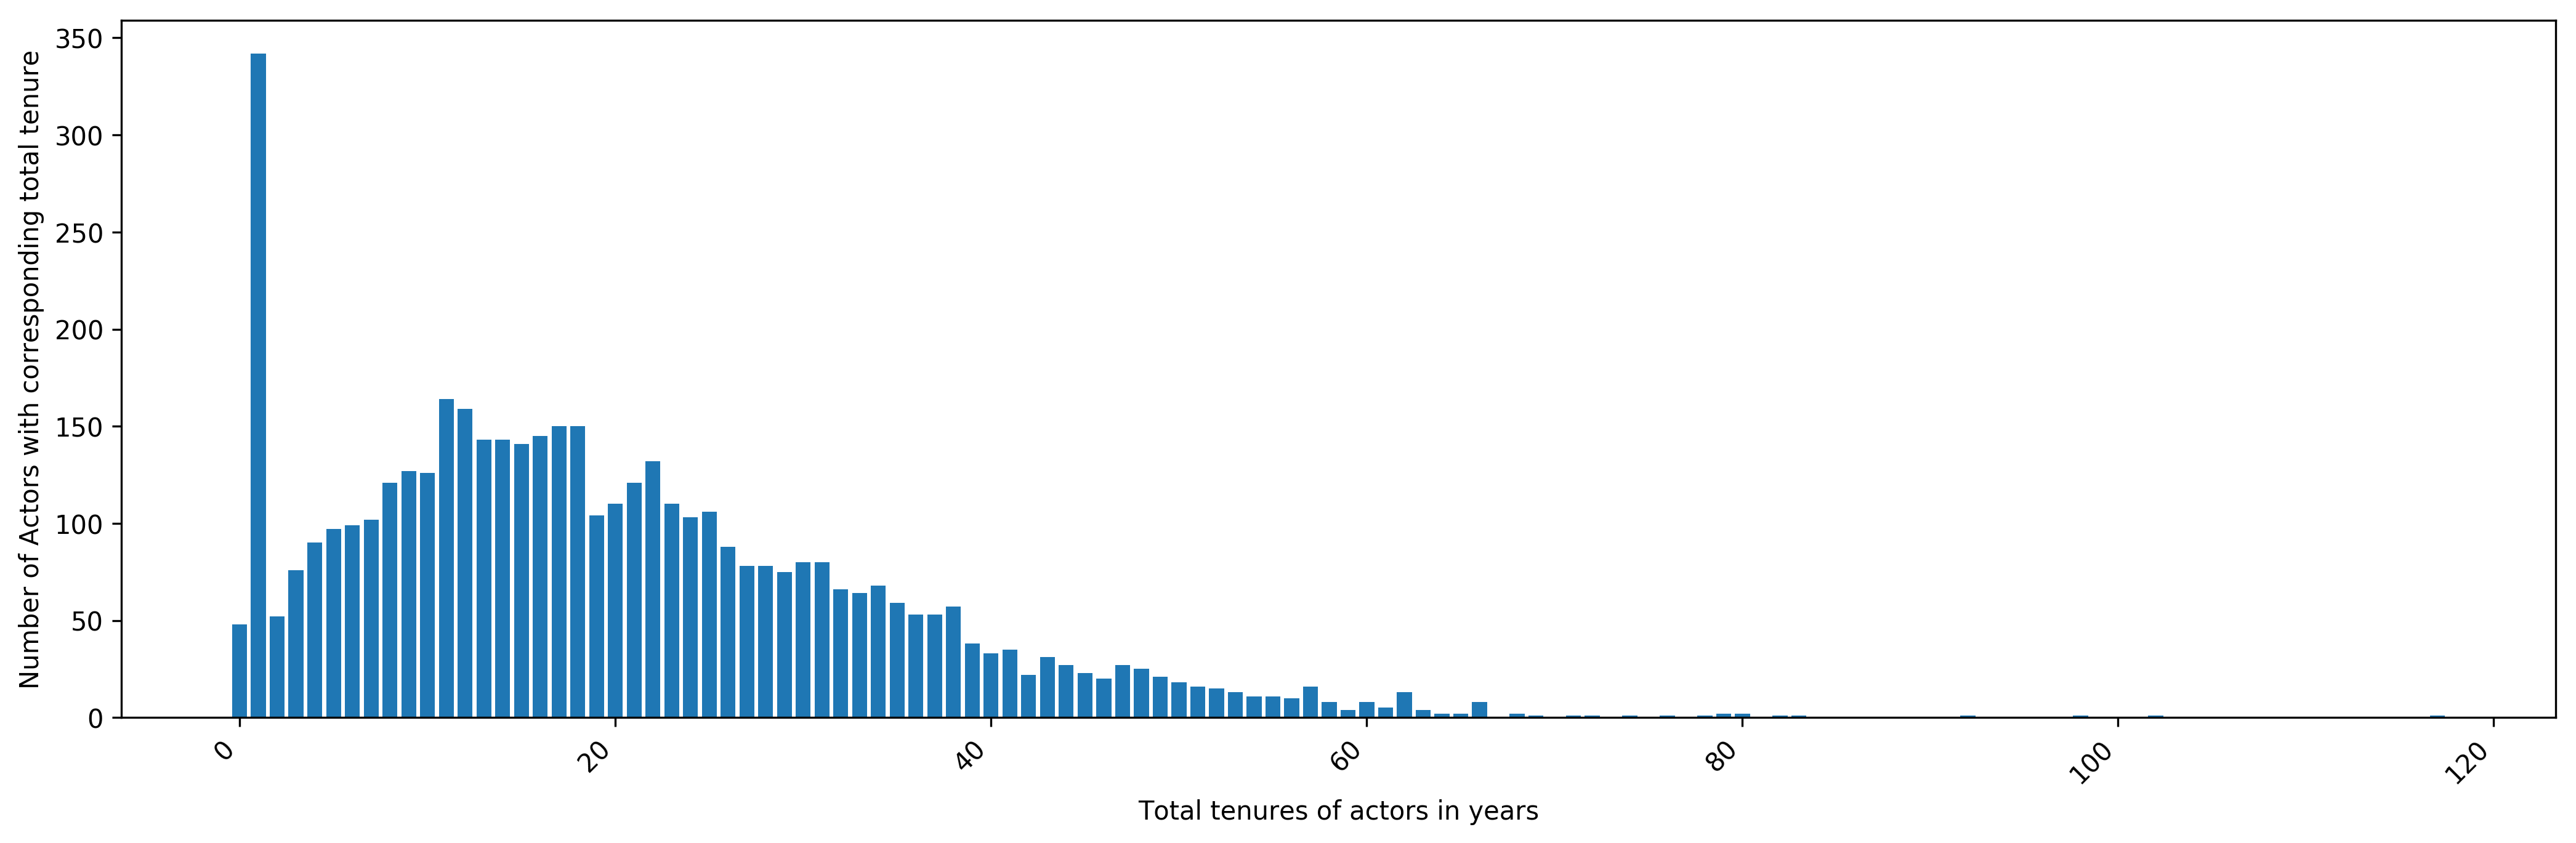

In [34]:
Image("images/tot_tenures_frequency_distri.png")

Then the distribution of the frequency of total tenures and averaged tenures of the movies were plot and it can be seen that this distribution is similar to a gaussian function.

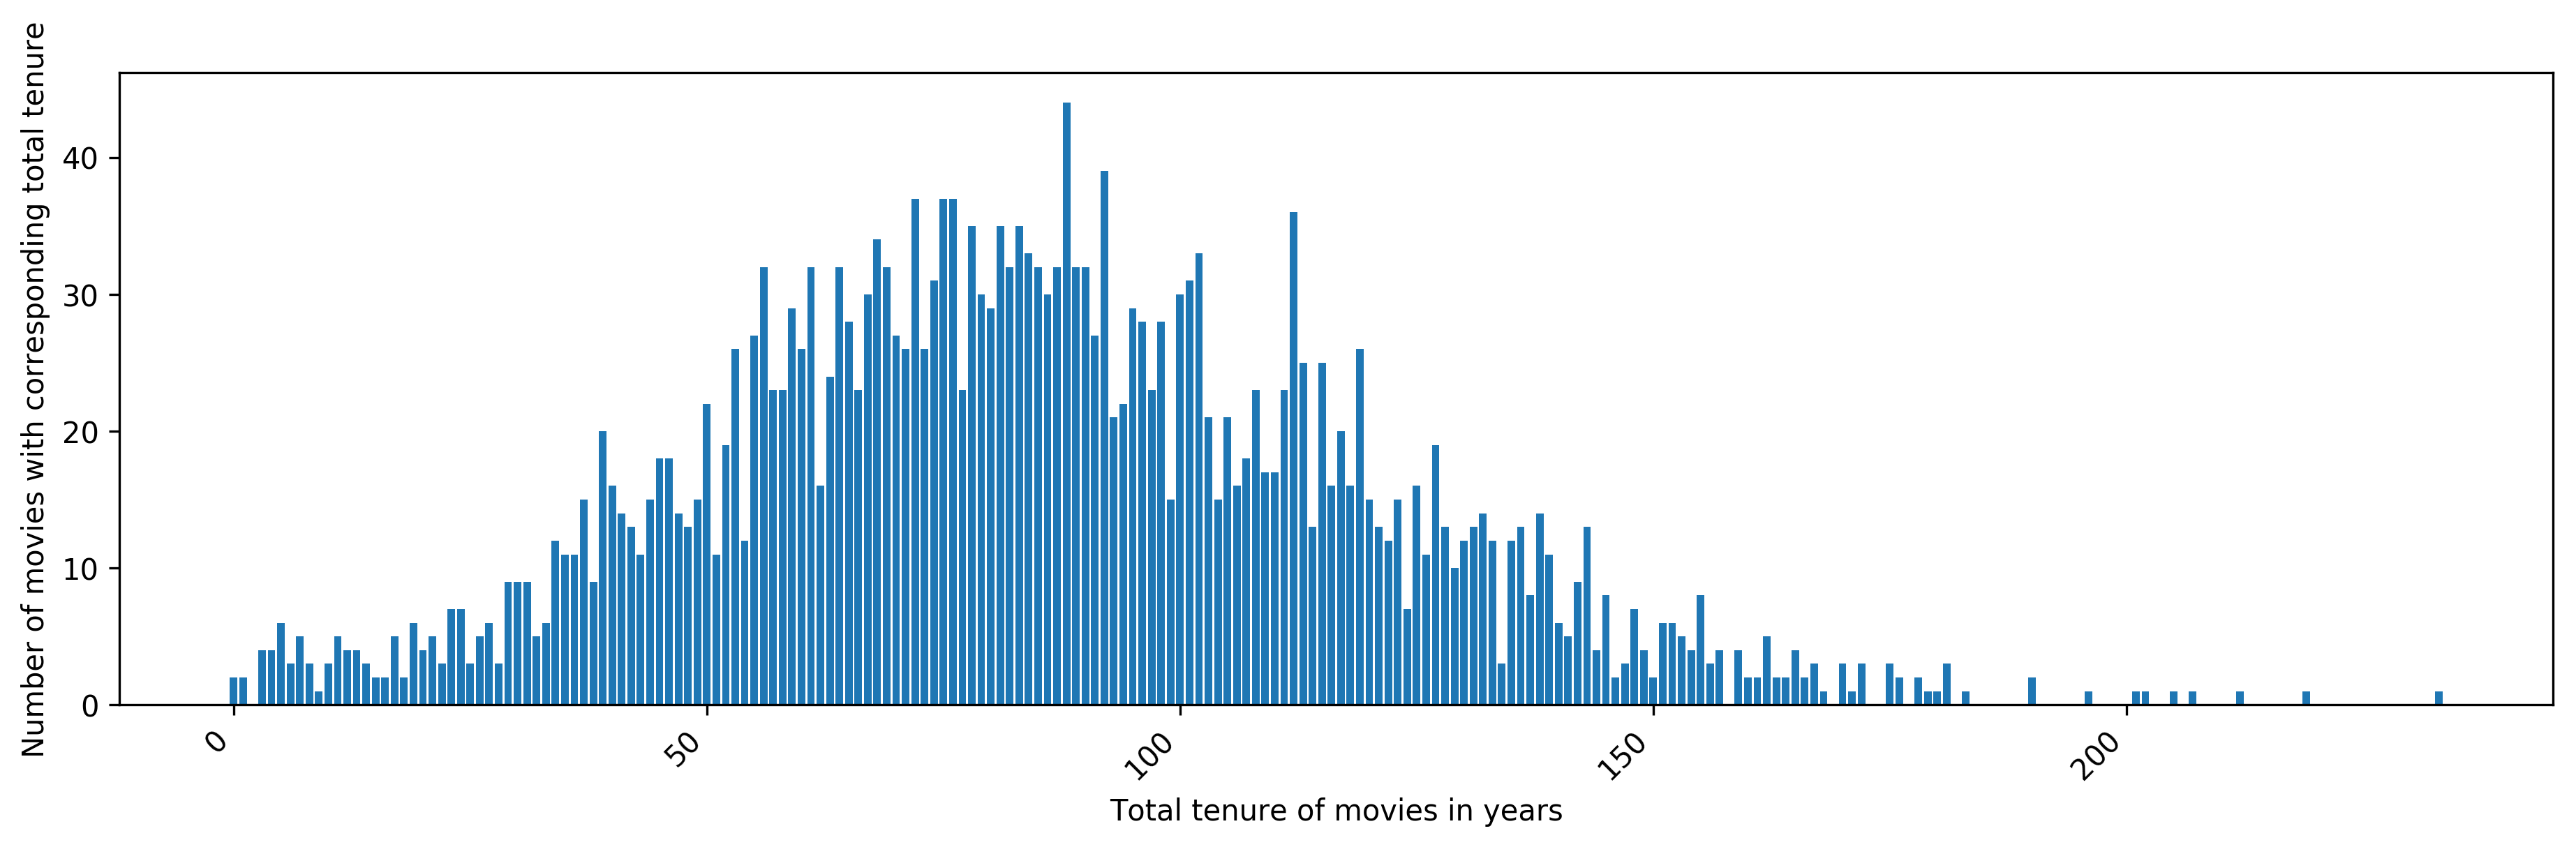

In [35]:
Image("images/sum_tenures_frequency_distri.png")

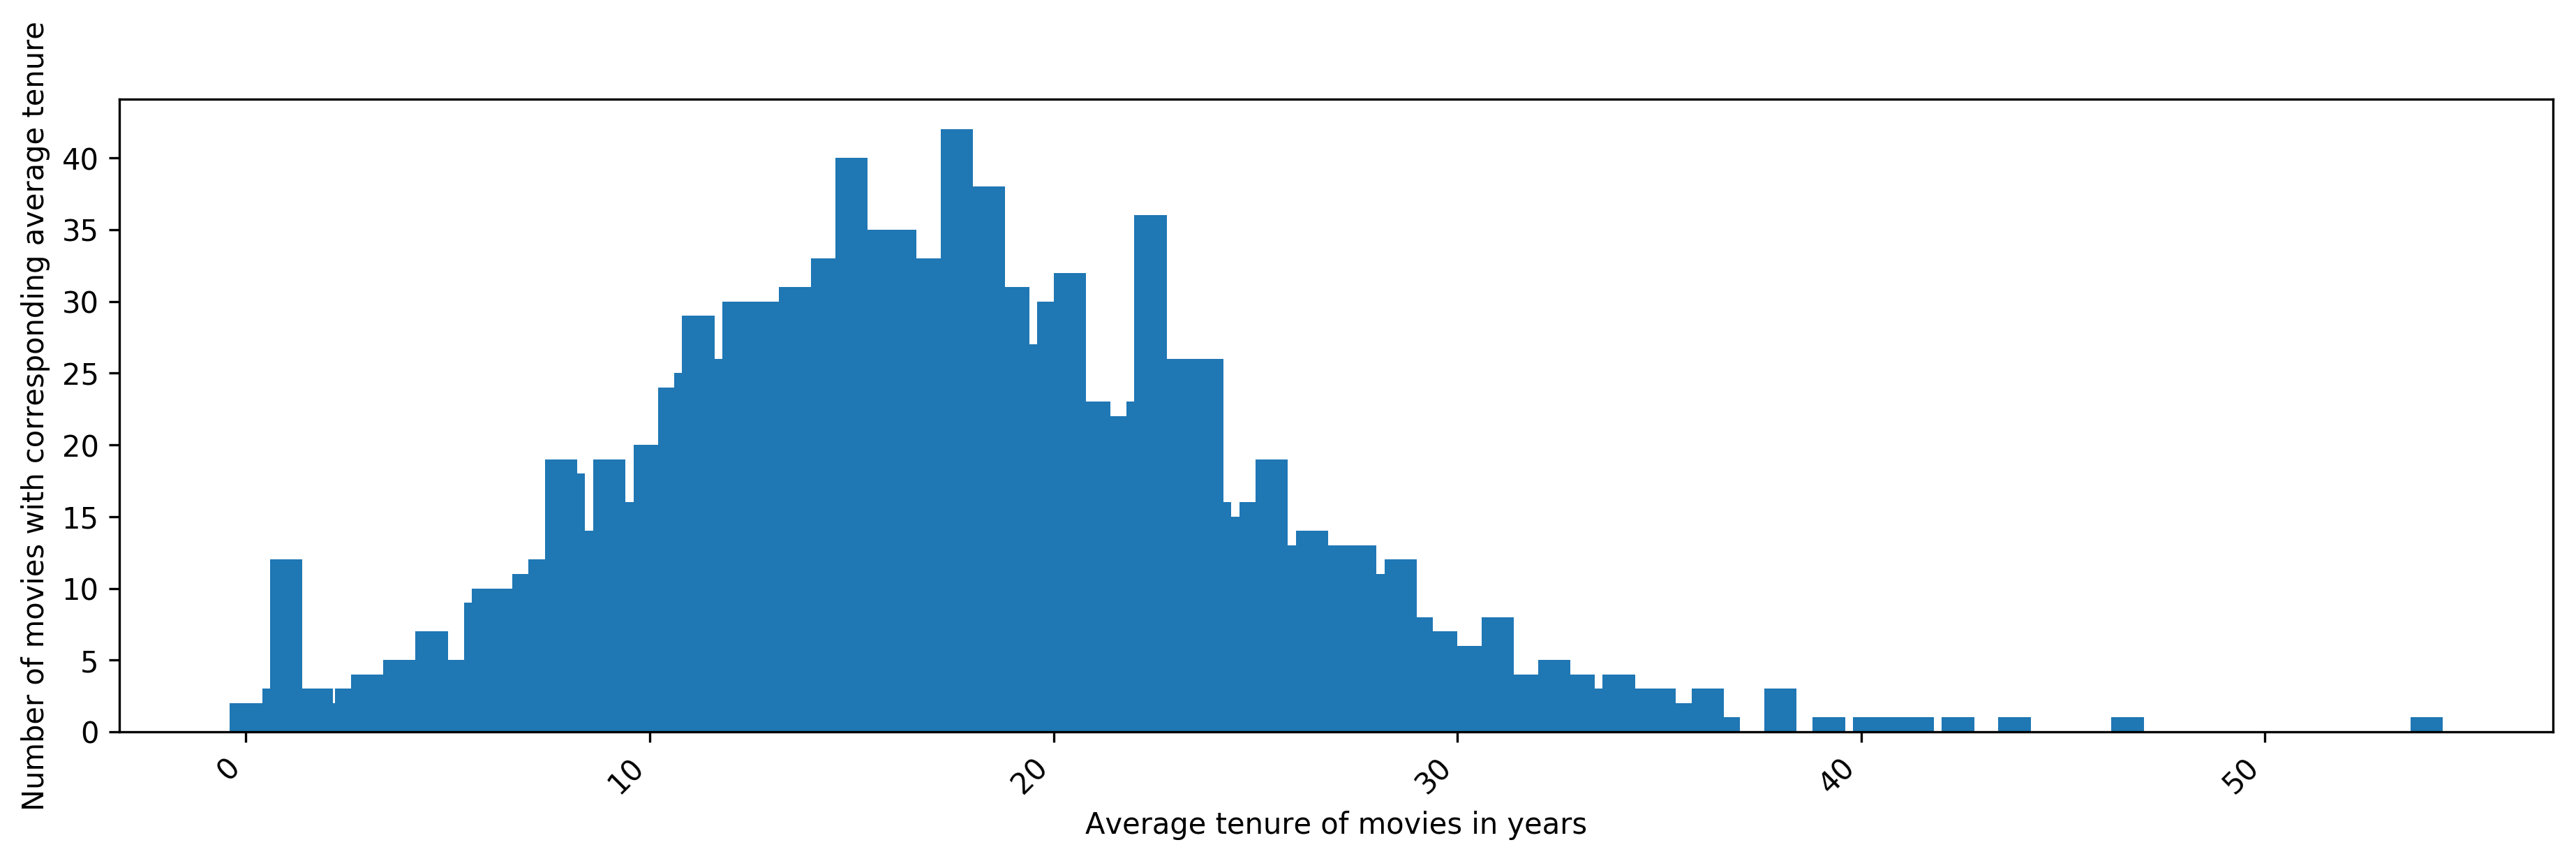

In [36]:
Image("images/avg_tenures_frequency_distri.png")

### 2.5 Directors###

In [37]:
all_director = list(df['director_name'])
diff_all_director = list(set(all_director))
print('There is {} different directors in the dataset'.format(len(diff_all_director)))

There is 1294 different directors in the dataset


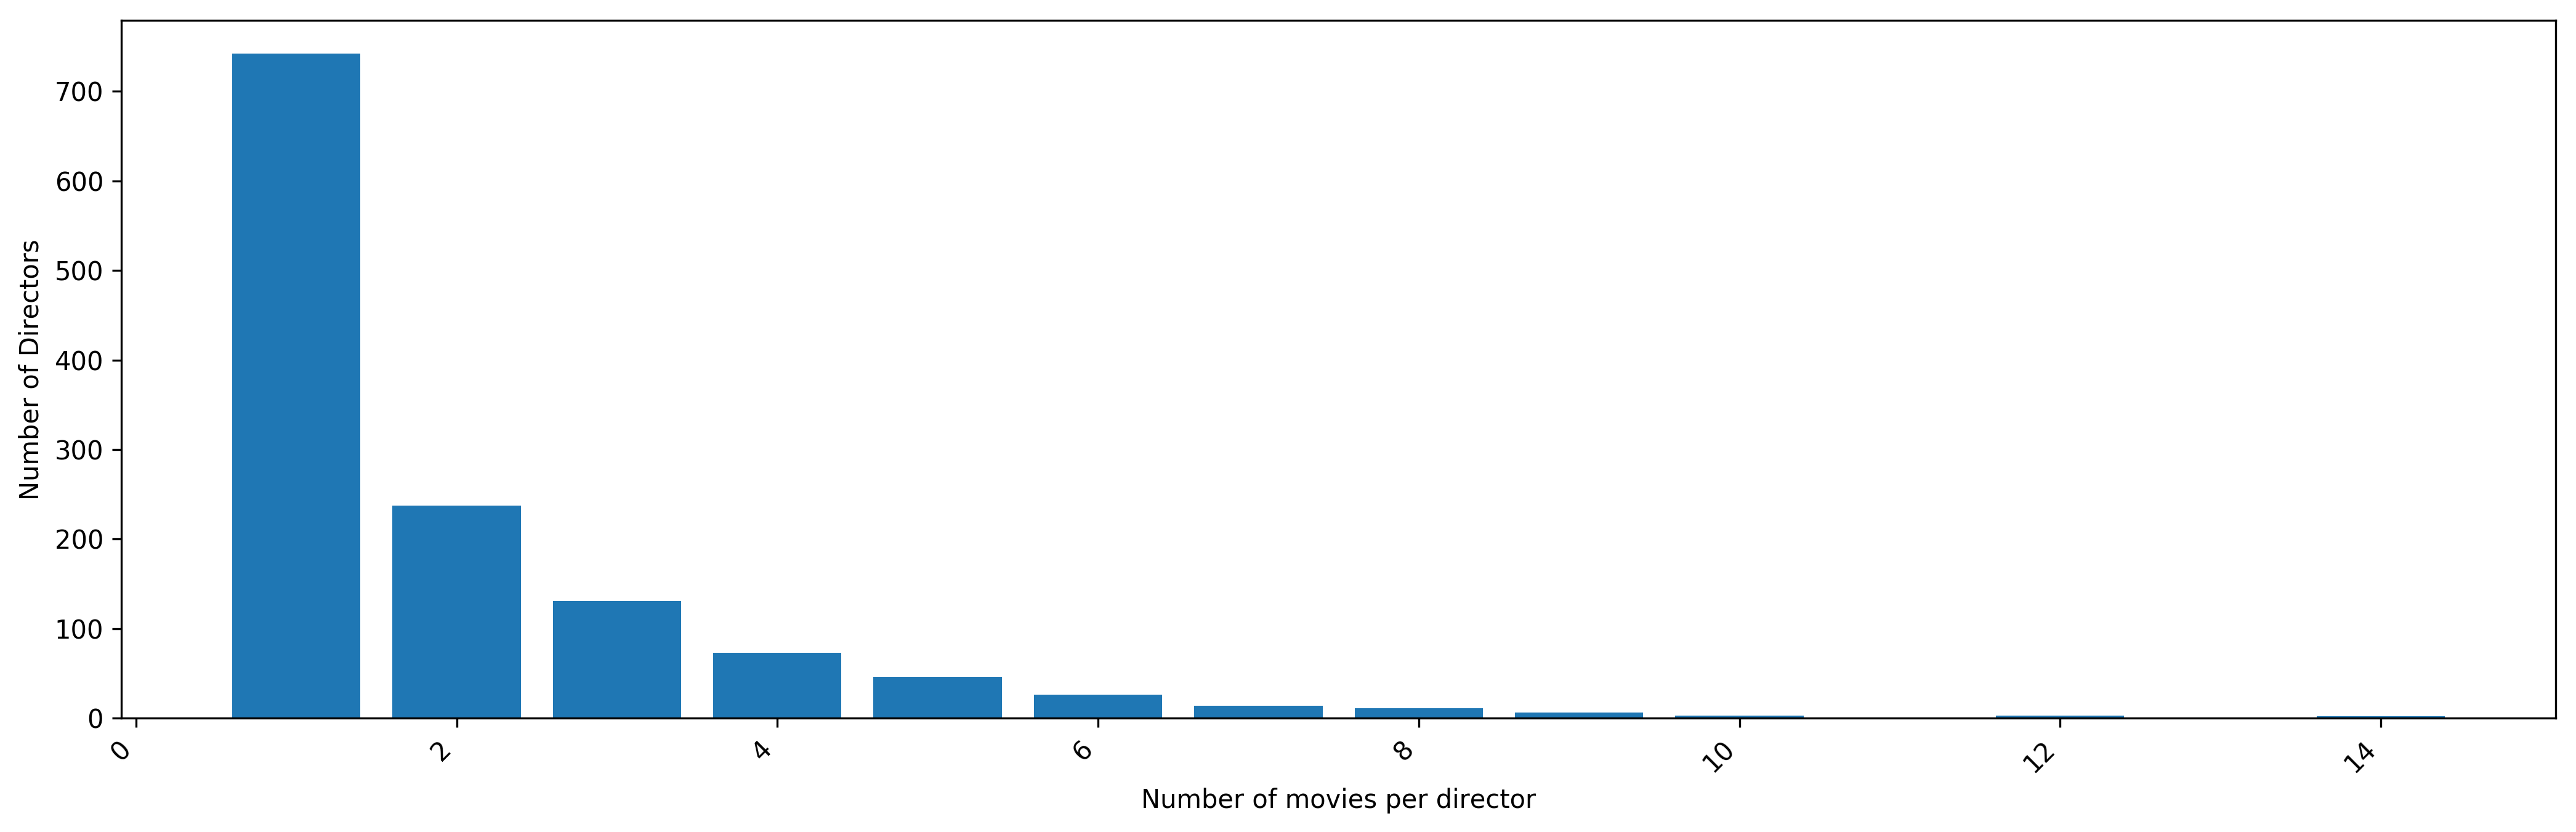

In [38]:
Image("images/nb_movie_per_dir.png")

As it can be seen in the distribution of the number of movies per director, there is a few percentage of the different directors in the dataset that have directed more than four movies. This features will be used in section exploitation to compare the movies.

### 2.6 Production companies  ###

In [39]:
#Compute list of different companies
all_comp = list(df['production_companies'])
diff_all_comp = list(set(all_comp))

print('There is {} different production companies in the dataset'.format(len(diff_all_comp)))

There is 701 different production companies in the dataset


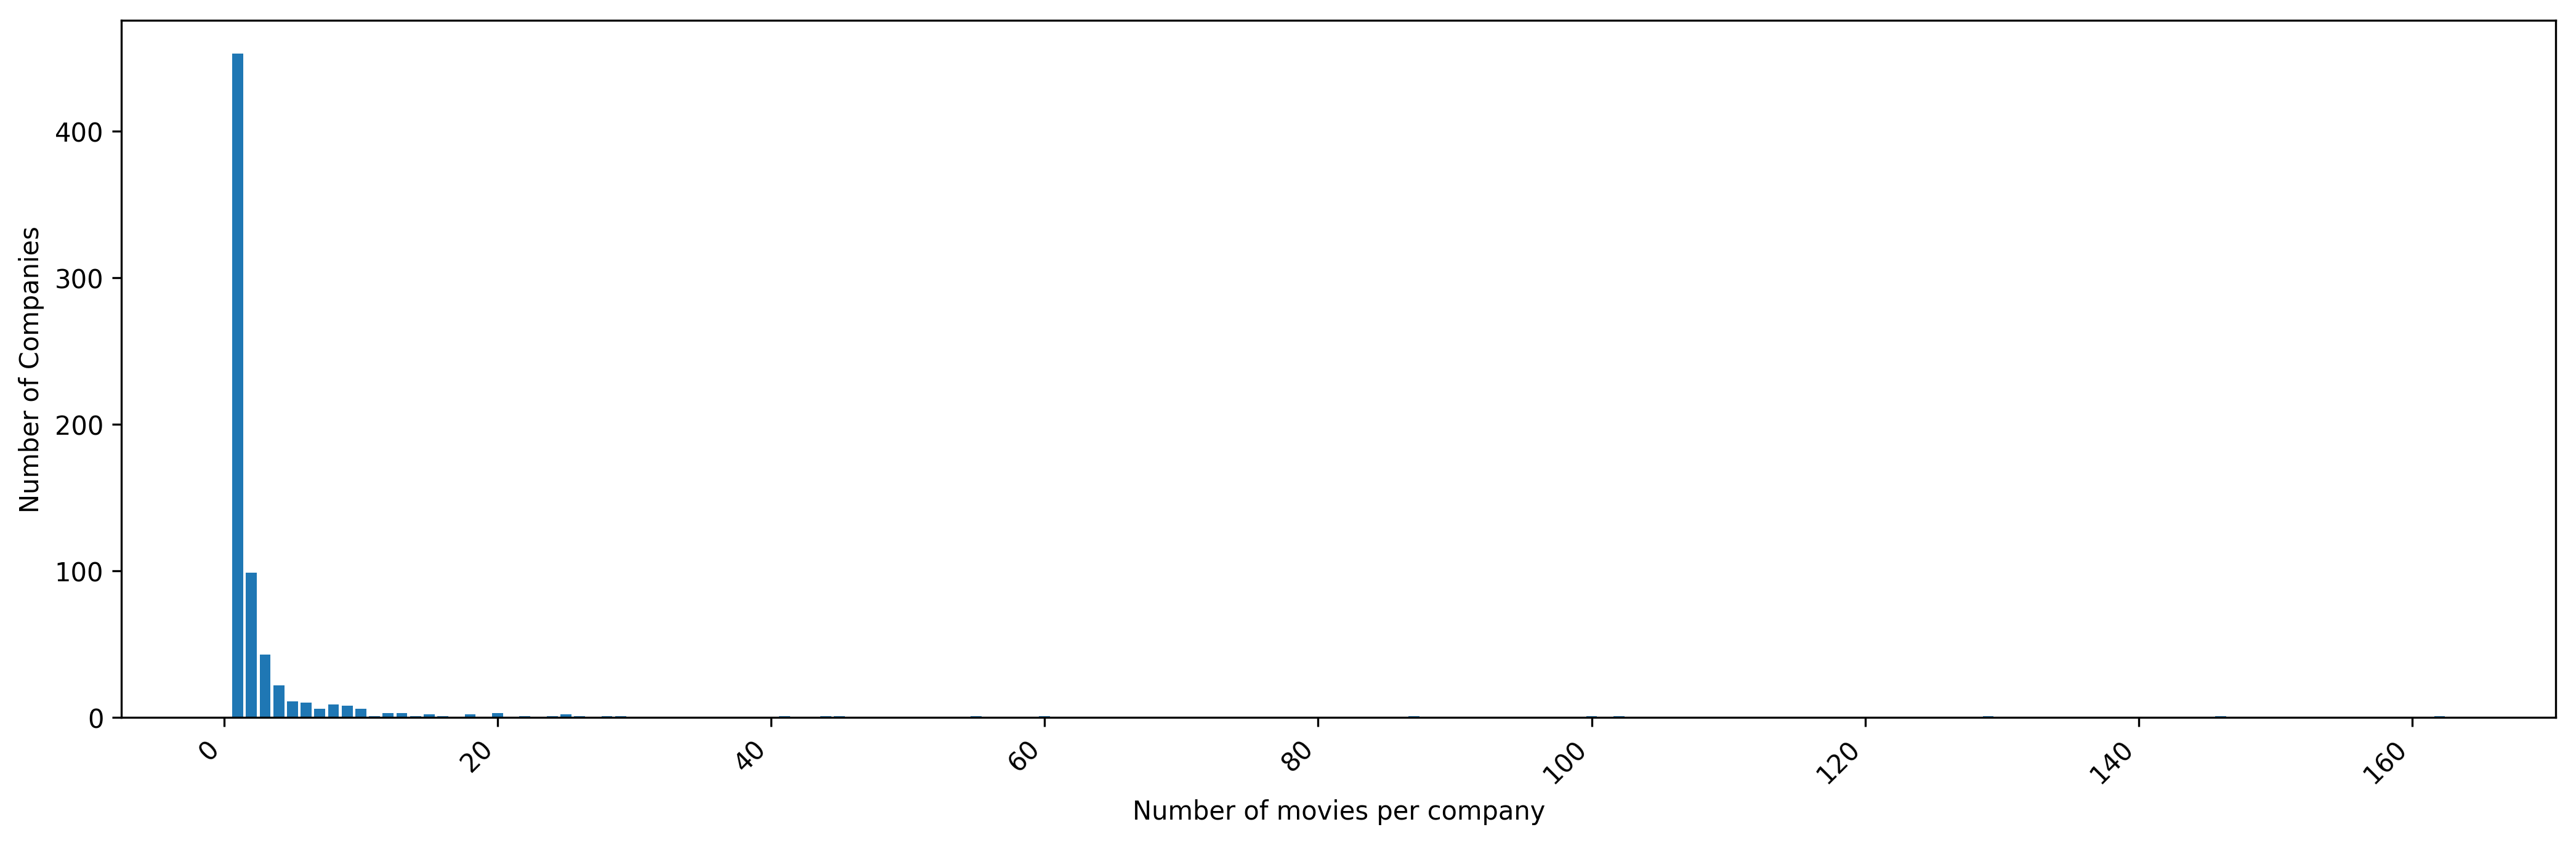

In [40]:
Image("images/nb_movie_per_company.png")

From this plot, it can be seen that most companies have only produced one or two films. In average a company have produced 3.74 movies in the dataset.

### 2.7. Storyline analysis ###

In this section, we want to explore the words contained in the movie's storyline. For example, which words apart from "stop words" are often used. To do this, the Natural Language Toolkit [5] was used to extract each word from the "overview" feature of the dataset and remove the "common words". Furthermore, to make this process easier, all words were set to lower case.

#### 2.7.1. Most common words ####

To determine the most common words, all of the remaining extracted words were put in a list and the following two commands were used:

* freq = nltk.FreqDist(Words) 
* freq.plot(30, cumulative=False)

Where "Words" is the list containing all the words. The first line of code uses the nltk library to compute the frequency at which the words from the list "Words" appear and the second one is used to plot the top N (in this case N = 30 for the sake of visualization) most frequent words. 

In [41]:
Wordsdf = pd.read_csv('Saved_Datasets/MostCommonWords.csv', encoding='latin')

In [42]:
Words = Wordsdf['0'][:].values.tolist()

Plot the number of times the top N most common words appear 

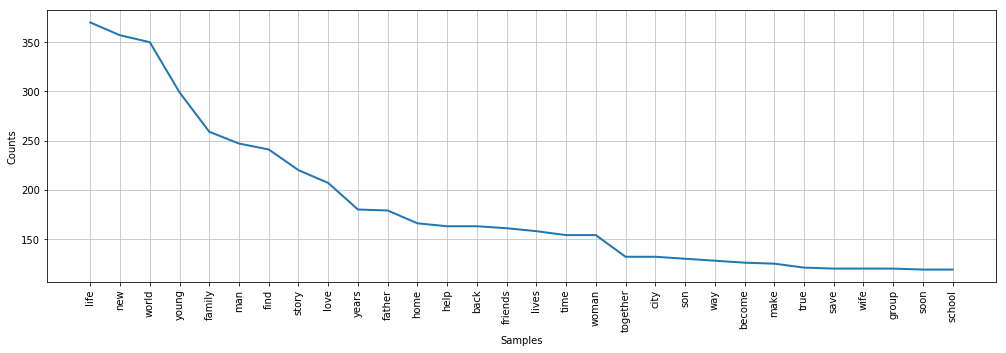

In [43]:
freq = nltk.FreqDist(Words) 
freq.plot(30, cumulative=False)

This can also be observed by using the following line of command 

In [44]:
freq.most_common(30)

[('life', 370),
 ('new', 357),
 ('world', 350),
 ('young', 299),
 ('family', 259),
 ('man', 247),
 ('find', 241),
 ('story', 220),
 ('love', 207),
 ('years', 180),
 ('father', 179),
 ('home', 166),
 ('help', 163),
 ('back', 163),
 ('friends', 161),
 ('lives', 158),
 ('time', 154),
 ('woman', 154),
 ('together', 132),
 ('city', 132),
 ('son', 130),
 ('way', 128),
 ('become', 126),
 ('make', 125),
 ('true', 121),
 ('save', 120),
 ('wife', 120),
 ('group', 120),
 ('soon', 119),
 ('school', 119)]

The 100 most frequently used words are then used for the similarity between movies and will be explained in the data exploitation.

#### 2.7.2. Success rate of the most common words ####

After determining the most commonly used words in our storylines, we can also determine their success rate. Only the top 14 are shown here:

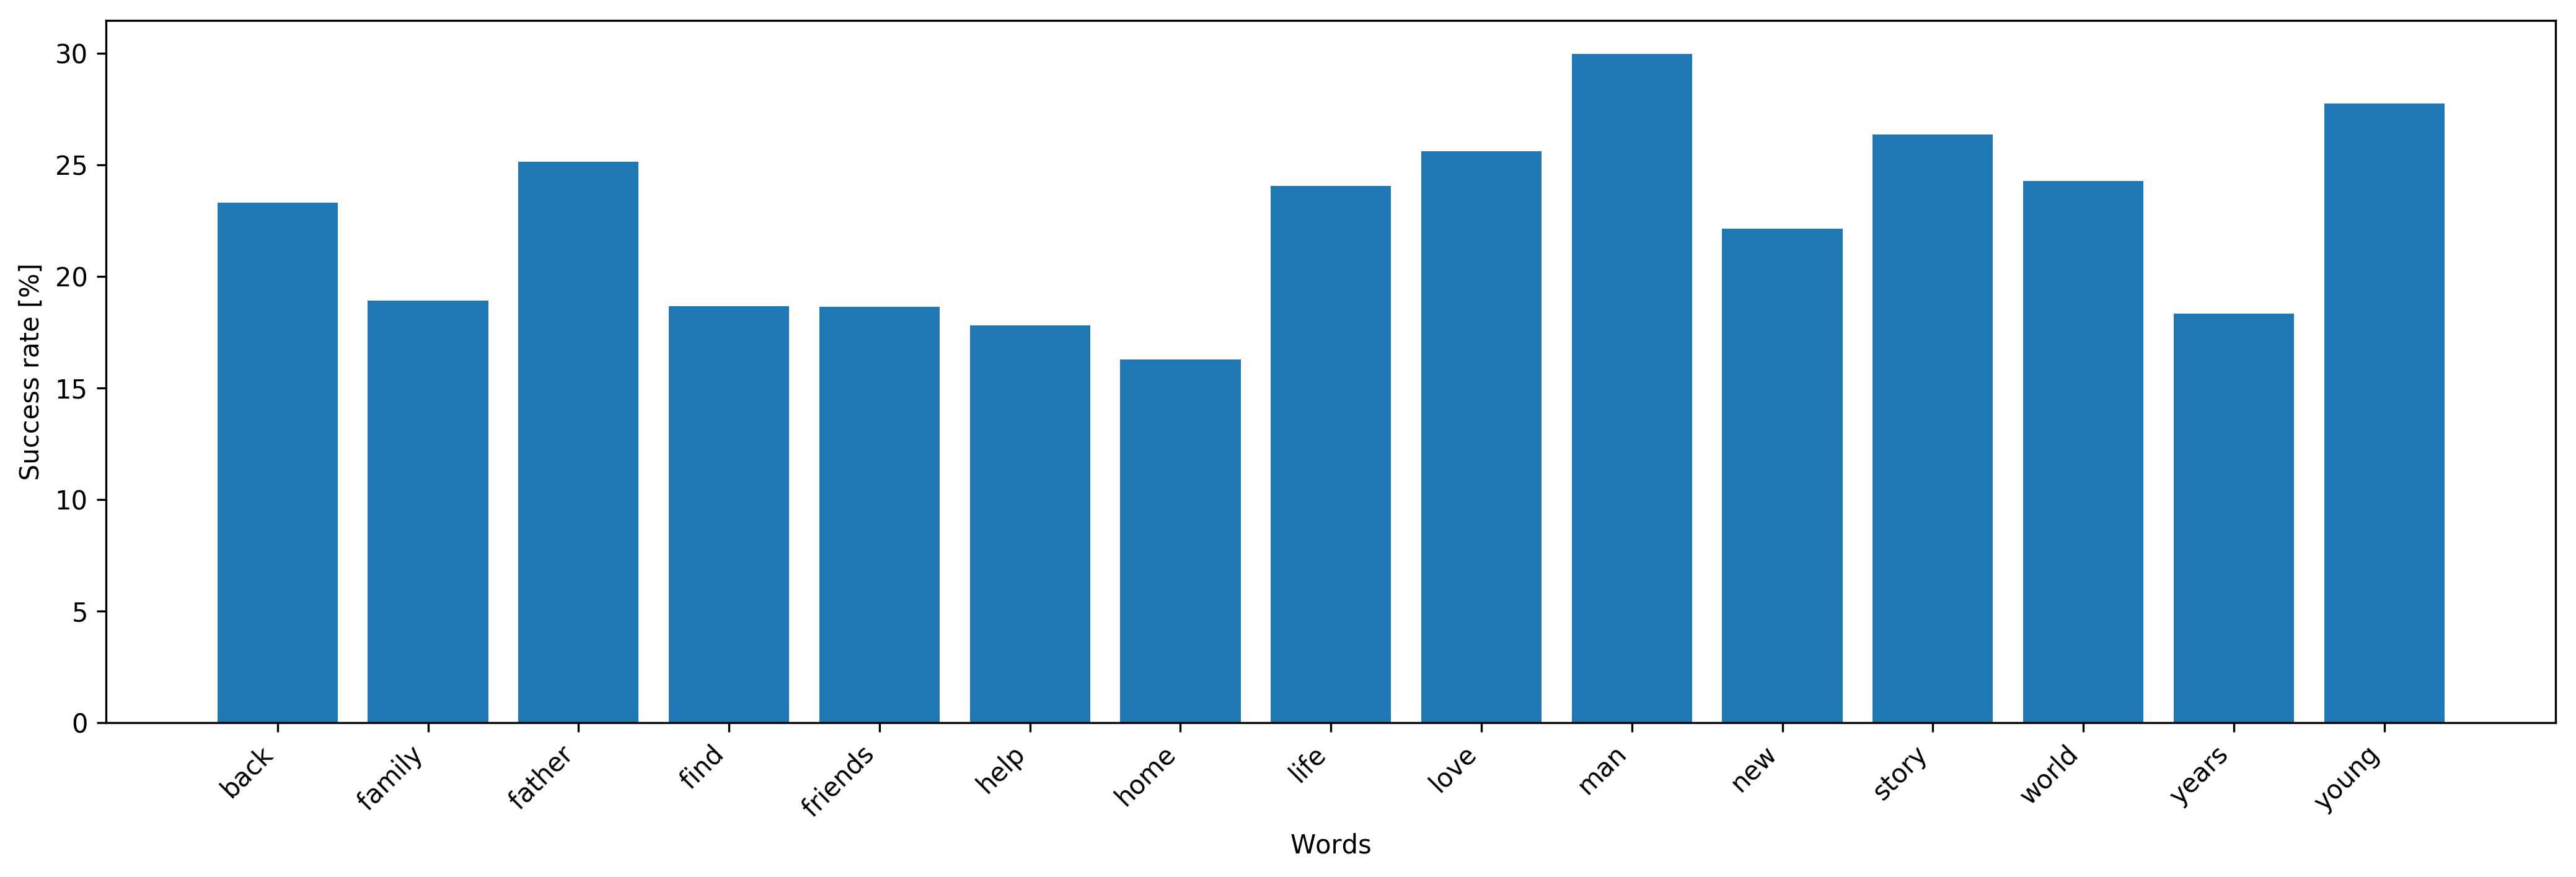

In [45]:
Image("images/TopSuccessWords.png")

We notice that the success of the most common words is not very high indicating that the storyline does not necessarily impact the success of the movie. This will be explored further later on in the data exploitation section.  

#### 2.7.3. Least common words ####

We can also determine the least common words used in our dataset. This will also allow us to observe what kind of words are never used and/or what kind of words or names were not removed during the language processing. 

In [46]:
last = nltk.FreqDist(dict(freq.most_common()[-30:]))
last

FreqDist({'allegiances': 1,
          'bolland': 1,
          'busker': 1,
          'city-wide': 1,
          'compartments': 1,
          'constraints': 1,
          'denier': 1,
          'dumpty': 1,
          'entries': 1,
          'evidenced': 1,
          'fletcher': 1,
          'g.': 1,
          'gems': 1,
          'gender': 1,
          'glenn': 1,
          'holocaust': 1,
          'humpty': 1,
          'libel': 1,
          'lipstadt': 1,
          'mirroring': 1,
          'observant': 1,
          'pakhtun': 1,
          'pakistan': 1,
          'pittsburgh': 1,
          'puss': 1,
          'scott-': 1,
          'softpaws': 1,
          'submerged': 1,
          'sues': 1,
          'visionary': 1})

As can be seen from this list, there are certain words or elements that were not removed from our set of extracted words such as 'g.'. Furthermore, certain verbs can be observed. To better treat these, we could have either used stemming or lemmatization. However, as these verbs did not seem to appear in the top 100 words that we will use later on, this was not done.  

### 2.8 Metacritic analysis ###

This section shows the distribution of the Metacritic ratings. It follows a Gaussian distribution:

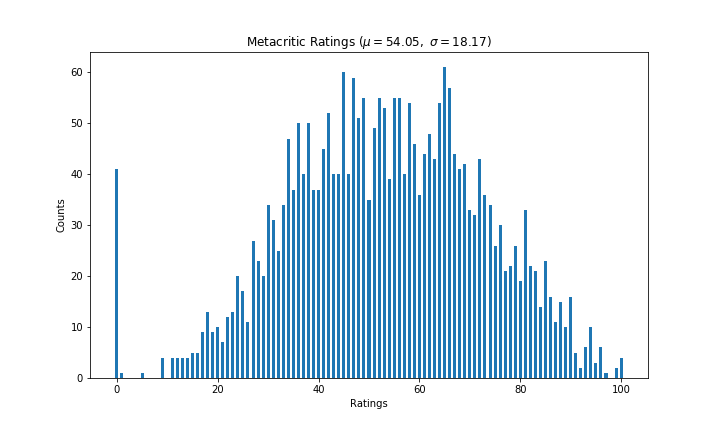

In [47]:
Image('images/Metacritic_distribution.png')

*The zeros are due to errors in the ratings and are ignored during the analysis*

#### 2.8.1. Metacritic ratings and ROI ####

We tried to find a correlation between the financial success of a movie, represented by the ROI, and the qualitative quality of a movie, reprensented by the metacritic ratings.

Here we see the ROI in function of the metacritic rating:

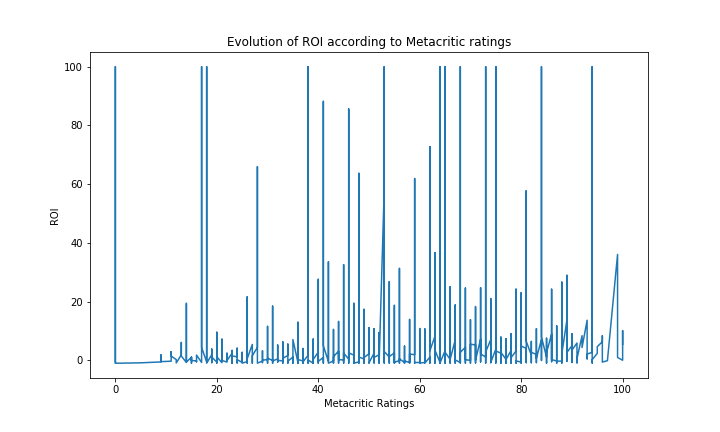

In [48]:
Image('images/roi_vs_metacritic.png')

As we can see, it appears that there is no correlation between the qualitative success and the financial success of a movie. This result can be explained because the revenue is highly influenced by the marketing and the visibility of a movie and a lot of people go to the theater to see movies they heard about, even if it's not a very good one.

### 2.9 YouTube Trailer Views

We collected videos from eight different channels, however three of them had less than 15% of the movies of our dataset. We kept these five ones, which contains around 35% of the videos of our dataset:

- Movieclips Trailers
- Movieclips Trailer Vault
- TrailersPlaygroundHD
- JoBlo Movie Trailers
- FilmIsNow Movie Trailers

By combining these sources, we achieved collecting almost 75% of the movies of our dataset. However, some movies have one trailer on each channel while others are found only once.

In [49]:
error = df.loc[df['YouTube_Mean']=='Error']
print("Number of trailers missing: "+str(len(error))+" ("+str(len(error)/len(df)*100)[:4]+"%)")

Number of trailers missing: 716 (27.3%)


To make the view count comparable between channels, we saturated it to the the value of the third quartile for each channel. Then, we normalized this number by the maximum views of each respective channel (i.e. the value of the third quartile since it's saturated).

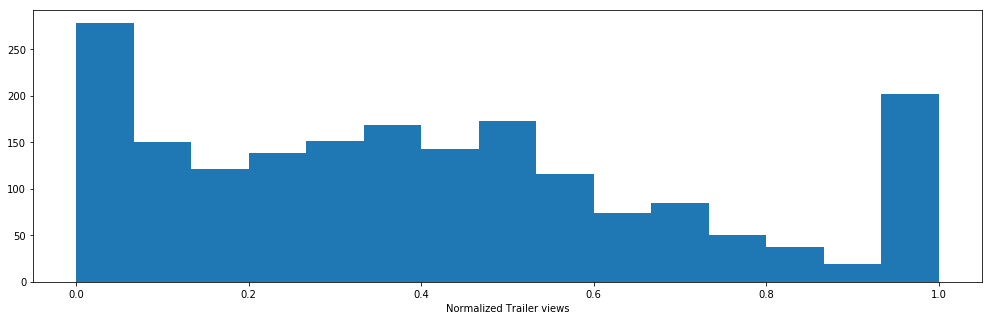

In [50]:
df_yt = df.drop(df[df['YouTube_Mean'] == 'Error'].index)
df_yt['YouTube_Mean'] = df_yt['YouTube_Mean'].astype(float)
plt.hist(df_yt['YouTube_Mean'],bins='auto');
plt.xlabel('Normalized Trailer views');

## 3. Data exploitation ##

To first determine if each feature had any impact on the success of the movie, similarity graphs were created between movies based on their genre, their storyline, the actors, etc. Graph embedding using Laplacian eigenmaps was then used in hope of potentially observing some separability in the data according to their labels.

### 3.1 Budget  ###

In this section, the goal is to observe if the budget of movies impacts their succes. A weight matrix was build by comparing the difference of budget between pairs of movies. 

The normalization of the weights was done as follows:
- $diff[i][j] = 0 : W[i][j] = 1$
- $diff[i][j] > 0 $ :  $W[i][j] = 1- \frac{W[i][j]}{max(W)}$

This gives the following matrix:

In [51]:
DiffNormBudgW = pd.read_csv('Saved_Datasets/DiffNormBudgW.csv')
DiffNormBudgW = DiffNormBudgW.as_matrix()

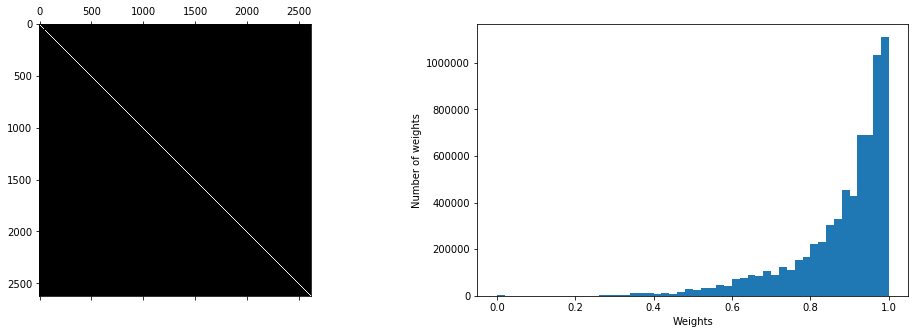

In [52]:
fix, axes = plt.subplots(1, 2)
axes[0].spy(DiffNormBudgW)
axes[1].hist(DiffNormBudgW.reshape(-1),bins=50);
axes[1].set_xlabel('Weights')
axes[1].set_ylabel('Number of weights')

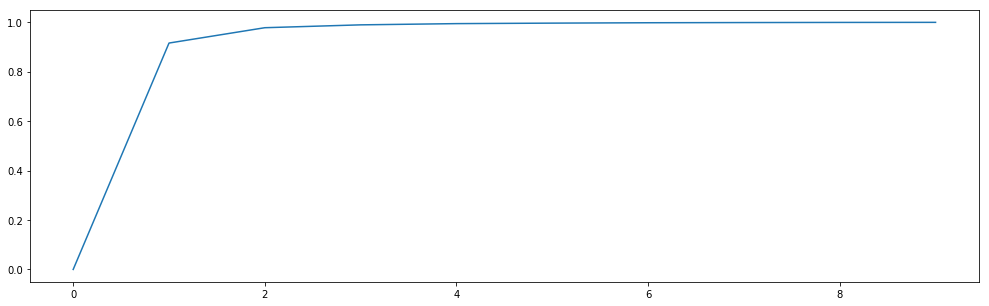

In [53]:
G_budg = graphs.Graph(DiffNormBudgW)
G_budg.compute_laplacian('normalized')
G_budg.compute_fourier_basis(recompute=True)
plt.plot(G_budg.e[0:10]);

From the graph of the eigenvalues, it can be seen that the first eigenvector explain 90% of the data.

In [54]:
labels = preprocessing.LabelEncoder().fit_transform(df['success'])
G_budg.set_coordinates(G_budg.U[:,1:3])

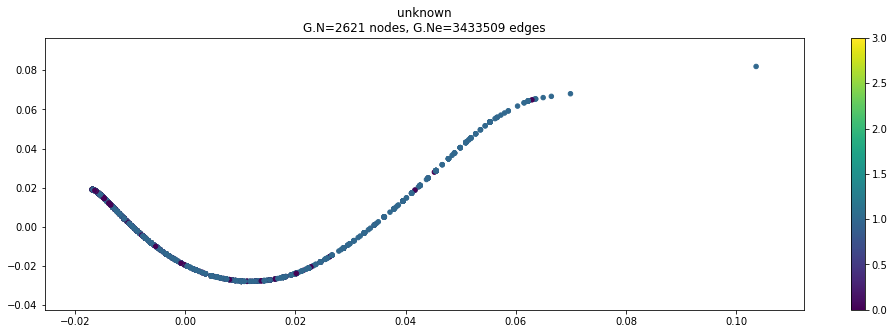

In [55]:
G_budg.plot_signal(labels, vertex_size=20,limits=[0,3])

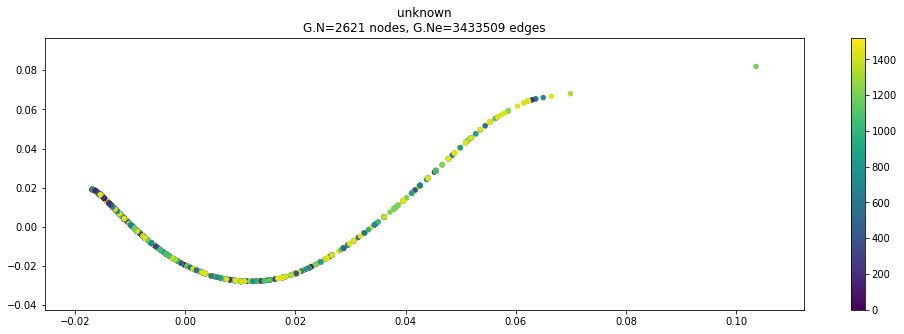

In [56]:
labels_reg = preprocessing.LabelEncoder().fit_transform(df['ROI'])
G_budg.plot_signal(labels_reg, vertex_size=20)

It can be seen that on the plot above the movies cannot be separated. Therefore it was tried to sparsify the matrix.

In [57]:
DiffSparsBudgW = pd.read_csv('Saved_Datasets/DiffNormSparsBudgW.csv')
DiffSparsBudgW = DiffSparsBudgW.as_matrix()

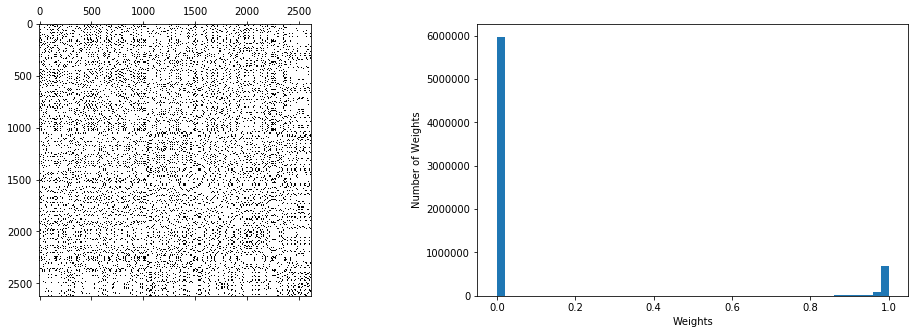

In [58]:
fix, axes = plt.subplots(1, 2)
axes[0].spy(DiffSparsBudgW)
axes[1].hist(DiffSparsBudgW.reshape(-1),bins=50);
axes[1].set_xlabel('Weights')
axes[1].set_ylabel('Number of Weights')

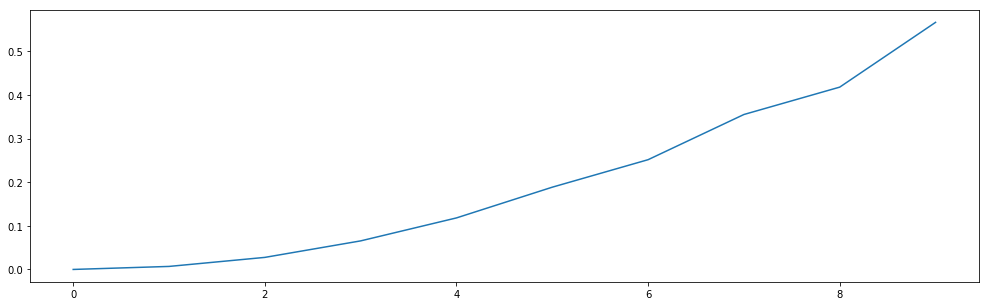

In [59]:
G_budg_sp = graphs.Graph(DiffSparsBudgW)
G_budg_sp.compute_laplacian('normalized')
G_budg_sp.compute_fourier_basis(recompute=True)
plt.plot(G_budg_sp.e[0:10]);

In [60]:
labels = preprocessing.LabelEncoder().fit_transform(df['success'])
G_budg_sp.set_coordinates(G_budg_sp.U[:,1:3])

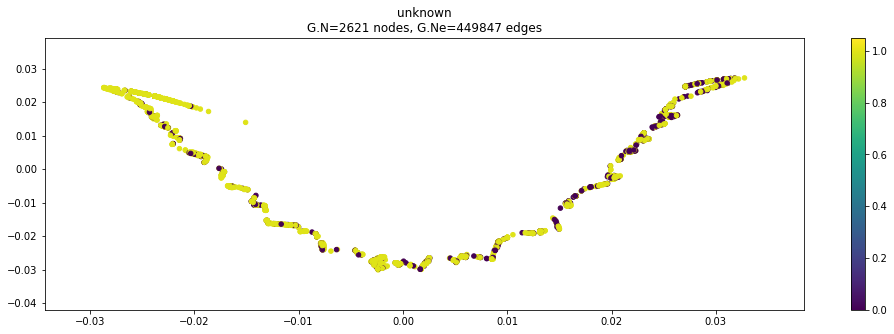

In [61]:
G_budg_sp.plot_signal(labels, vertex_size=20)

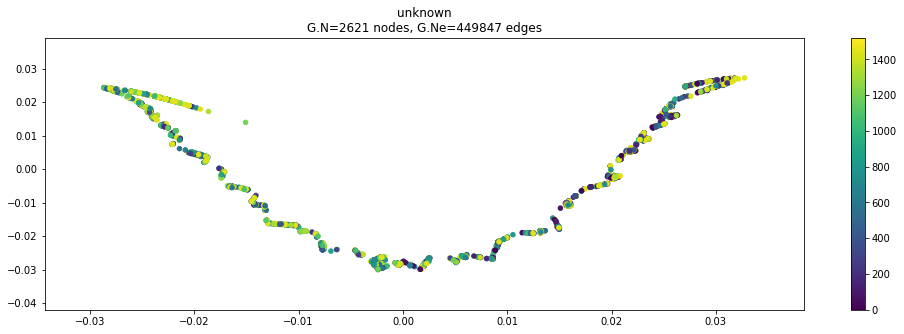

In [62]:
G_budg_sp.plot_signal(labels_reg, vertex_size=20)

Despite sparsifying the weight matrix, the data can still not be separated. 

### 3.2. Genre ### 

#### 3.2.1 Similarity graph ####

A similarity graph between movies was created based on whether a pair of movies were of the same genres. Initially, for each pair, we determined how many genres the pair had in common and divided the resulting value by the number of genres of the movie containing the most genres between the pair:

For example, with film i and j, we have:

$W_{ij} = \frac{Number \ of \ similar \ genres \ between \ i \ and \ j}{Highest \ number \ of \ genres \ between \ i \ and \ j}  \in [0; 1]$

A value of 1 would indicate complete similarity in terms of genre and a value of 0 would therefore indicate zero similarity in terms of genre.

However, as can be seen in the plot below, graph embedding with Laplacian eigenmaps on the second and third eigenvectors did not give us a good representation of the data. Indeed, despite the first two eigenvalues seemingly representing most of the variability of the data, from the plot we can see that this is mostly due to a dozen datapoints which are far from most of the others.

In [63]:
GenreW = pd.read_csv('Saved_Datasets/NormalizedGenreW.csv')

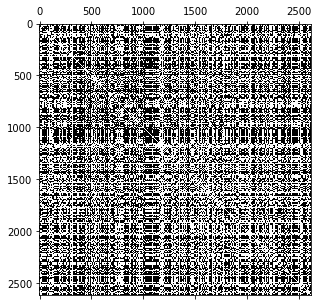

In [64]:
plt.spy(GenreW)

Computation of the normalized Laplacian of this weighted graph.

In [65]:
Ggenre = graphs.Graph(GenreW)
Ggenre.compute_laplacian('normalized')

Display of its eigenvalues

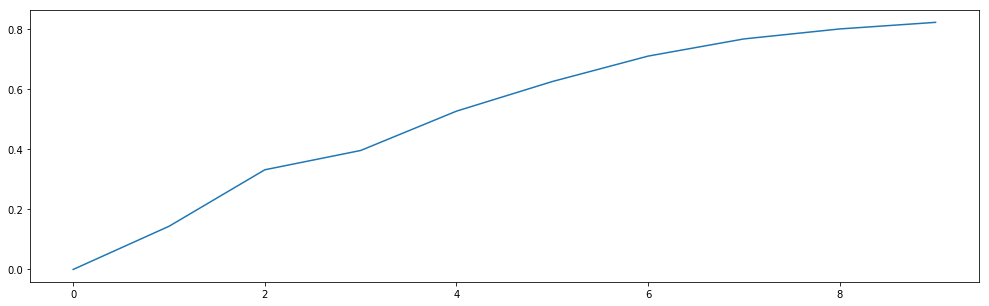

In [66]:
Ggenre.compute_fourier_basis(recompute=True)
plt.plot(Ggenre.e[0:10]);

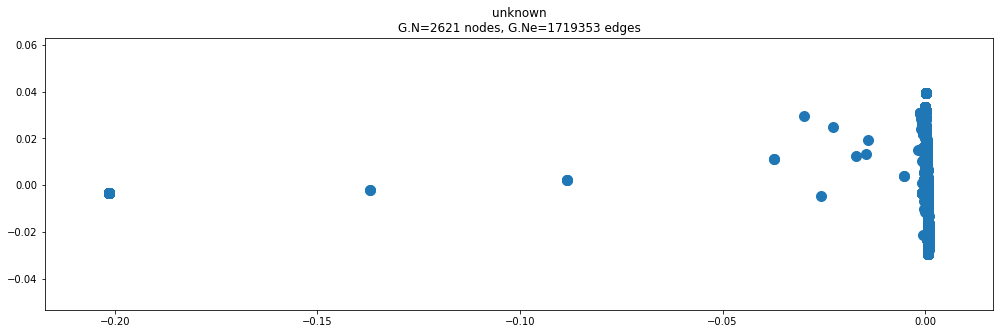

In [67]:
Ggenre.set_coordinates(Ggenre.U[:, 1:3])
Ggenre.plot()

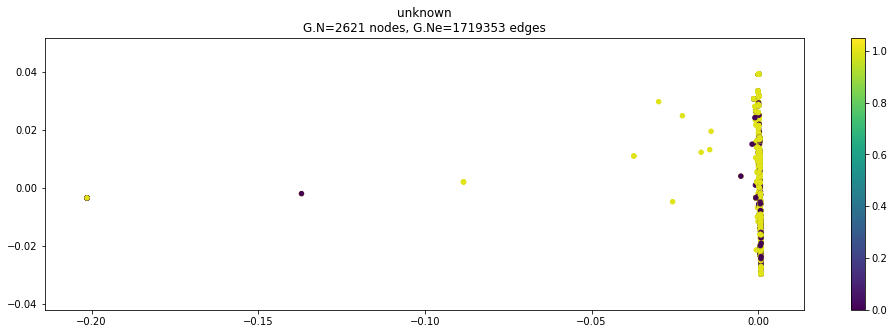

In [68]:
genres = preprocessing.LabelEncoder().fit_transform(df['success'])
Ggenre.plot_signal(genres, vertex_size=20)

We could of course embed this graph on another pair of eigenvectors, however we later wish to create a similarity graph by combining all of these subgraphs together. Since the variability should always be greatest along the first two eigenvectors as they are sorted, it would be best to find a normalization that gives us a better representation of the data when embedded on these eigenvectors.

As such, we decided to do another normalization by considering the 75-percentile of the weights. The 75th percentile value indicated that most pairs of movies had a similarity between 0 and 1 in terms of genre. However, as can be seen in the histogram of number of movies per genre, almost half of the movies have the genre "drama". As such, it was decided to consider that all pairs of movies that have 2 or more similar genres would have a weight of 1 whereas those of 1 similar genre should have a weight of 0.5 and those of 0 similar genres should have 0:

$$W_{ij} \begin{cases}1 & Nb \ similar \ genres \geq 2\\0.5 & Nb \ similar \ genres = 1 \\ 0 & Nb \ similar \ genres =0 \end{cases}$$

The graph was then sparsed such that only 300 of the most important neighbours was kept. 

In [69]:
GenreW = pd.read_csv('Saved_Datasets/NormalizedGenreWSparse.csv')

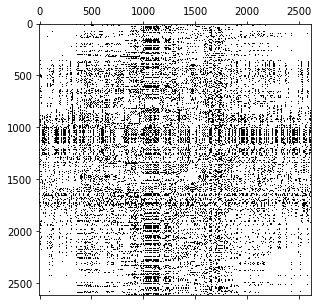

In [70]:
plt.spy(GenreW)

#### 3.2.2. Graph Laplacian ####

In [71]:
Ggenre = graphs.Graph(GenreW)
Ggenre.compute_laplacian('normalized')

#### 3.2.3. Graph embedding: Laplacian eigenmaps #### 

Display of the Laplacian's eigenvalues

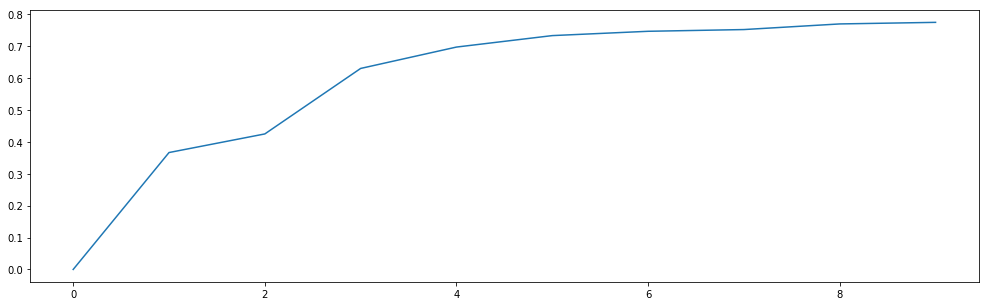

In [72]:
Ggenre.compute_fourier_basis(recompute=True)
plt.plot(Ggenre.e[0:10]);

Embed the graph on the first two eigenvectors

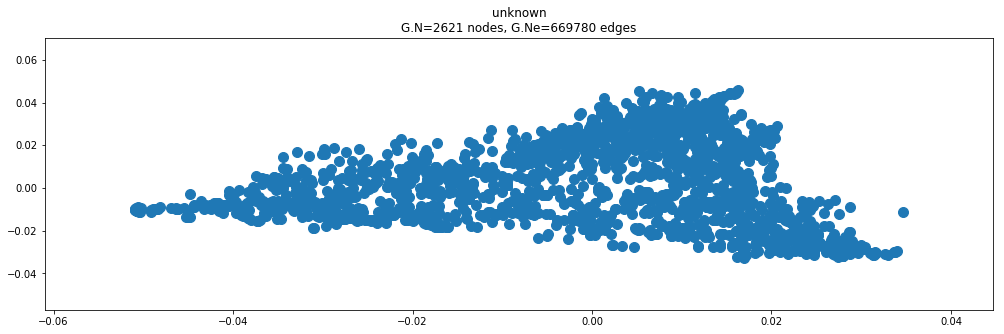

In [73]:
Ggenre.set_coordinates(Ggenre.U[:, 1:3])
Ggenre.plot()

##### 3.2.3.1. Classification #####

We then assign a signal to our datapoints according to the notion of success defined previously with the ROI to observe whether the data would potentially be separable along one or both of the eigenvectors.  

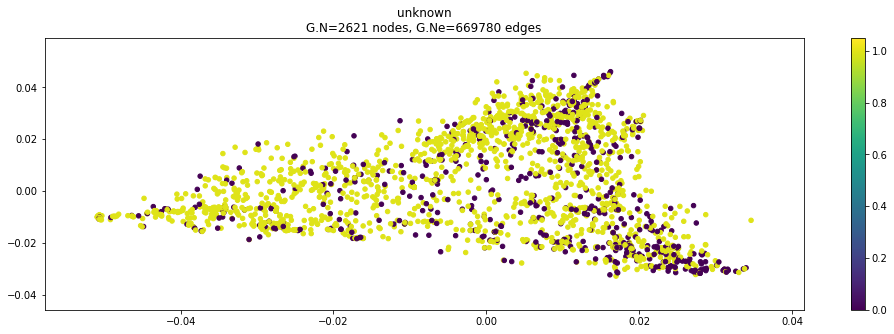

In [74]:
genres = preprocessing.LabelEncoder().fit_transform(df['success'])
Ggenre.plot_signal(genres, vertex_size=20)

From this plot, we observe that the two classes do not seem to be separable along any of these eigenvectors. Unsurprisingly, this would indicate that the genres of a movie do not seem to greatly impact the success of a movie.

##### 3.2.3.2. Regression #####

In this case we directly assign the ROI of the movie as label for each datapoint to observe whether movies with similar text words generated the same values of ROI. 

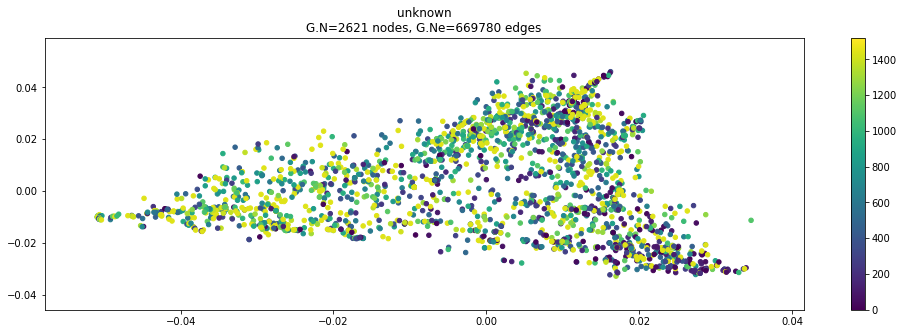

In [75]:
genres_reg = preprocessing.LabelEncoder().fit_transform(df['ROI']/2.64)
Ggenre.plot_signal(genres_reg, vertex_size=20)

### 3.3 Actors in movies ###

#### 3.3.1 Actors in common between pairs of movies ####

In this section the actors in common bewteen movies is studied. The actors names between movies were compared and the weight on the edges of the graph is equal to the number of actor in common between the movies. Since there is only the five principals actors of each movies in the dataset, there can be maximum five actors in common between two movies.

The normalization of the weight matrix is then done as follow:
- If $0 ≤ W[i][j] ≤ 3$: $W[i][j] = \frac{W[i][j]}{3}$
- If $ W[i][j] > 3$ : $W[i][j] = 1$

It is very rare that two movies have more than 3 actors in common an if it is the case, it is considered that the two movies are very similar. This way of normalizing weights allow to give more weights to movies that have only one actor in common which is yet not very common.

In [76]:
NormActW = pd.read_csv('Saved_Datasets/Normalized2ActorW.csv')
NormActW = NormActW.as_matrix()

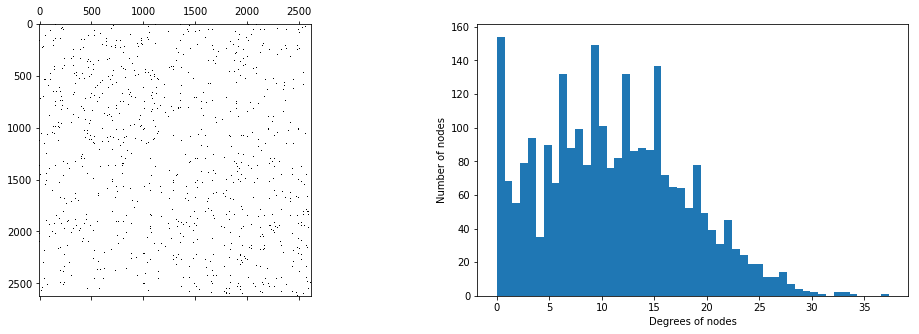

In [77]:
#Compute degree distribution 
deg_Act = np.zeros(len(NormActW)) 
for i in range(0, len(NormActW)):
    deg_Act[i] = sum(NormActW[i])

fix, axes = plt.subplots(1, 2)
axes[1].hist(deg_Act.reshape(-1), bins=50);
axes[1].set_xlabel('Degrees of nodes')
axes[1].set_ylabel('Number of nodes')
axes[0].spy(NormActW)

As it can be seen in the degrees distribution, some nodes have a degree of 0 which means that some movies are not connected to the graph because there are not similar to any other movie. However, it is impossible to compute de laplacian if there is nodes with a degree of 0.

#### 3.3.2 Similarity in actors tenures between pairs of movies ####

As explained in section data exploration, the total tenures of actors and the averaged tenures of actors in the dataset were computed. The idea is now to study if the fact that actors have a long career impacts the sucess of a movie. Therefore, the difference between the total tenures of pairs of movies, which is the sum of all the tenures of the actors present in the movies, was computed. This difference allows then to compute the weight matrix.

Several kernel of normalization were tried like a gaussian kernel, normalizing by the maximum weight, normalizing by exp(-x) but in each of these normalization type, the normalized weights were not corresponding to the expected behavior. Normalizing the weights by dividing the values by the 3rd percentile of the weights appeared as the best solution.

The weights were then normalized as follows:
- $diff[i][j] = 0 : W[i][j] = 1$
- 0 < $diff[i][j] <= $ 3rd percentile of diff: $W[i][j] = 1- \frac{W[i][j]}{3rd \ percentile \ of \ diff}$
- $diff[i][j] > $ 3rd percentile of diff : $W[i][j]=0$

In this case, the 3rd percentile of weight matrix was 55, which means that 75% of the differences of the total tenures between pairs of movies is comprising between 0 and 55.

In [78]:
NormActTenW = pd.read_csv('Saved_Datasets/DiffNorm75ActTenW.csv')
NormActTenW = NormActTenW.as_matrix()

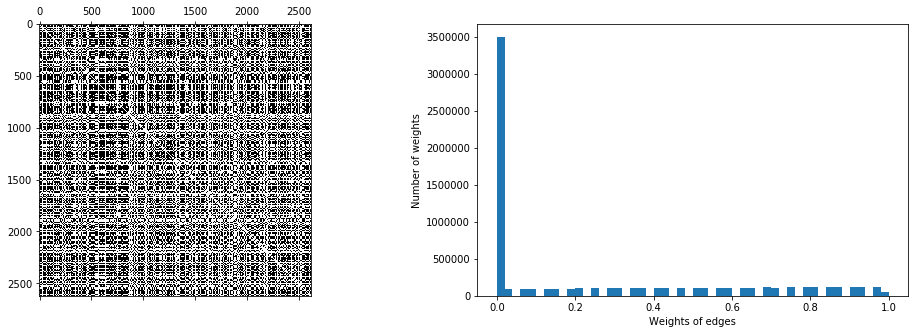

In [79]:
fix, axes = plt.subplots(1, 2)
axes[0].spy(NormActTenW)
axes[1].hist(NormActTenW.reshape(-1), bins=50);
axes[1].set_xlabel('Weights of edges')
axes[1].set_ylabel('Number of weights')

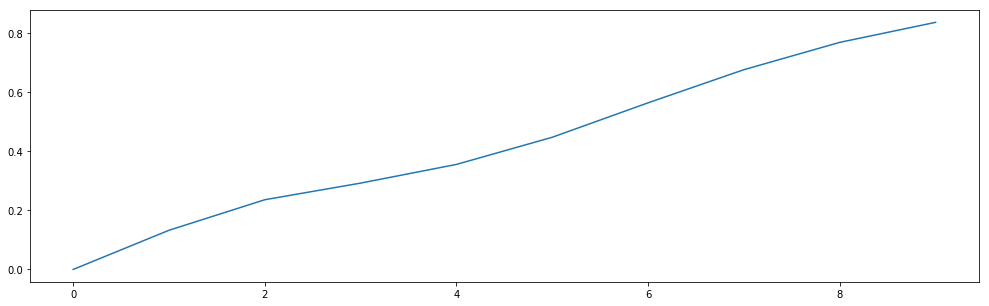

In [80]:
G_act_ten = graphs.Graph(NormActTenW)
G_act_ten.compute_laplacian('normalized')
G_act_ten.compute_fourier_basis(recompute=True)
plt.plot(G_act_ten.e[0:10]);

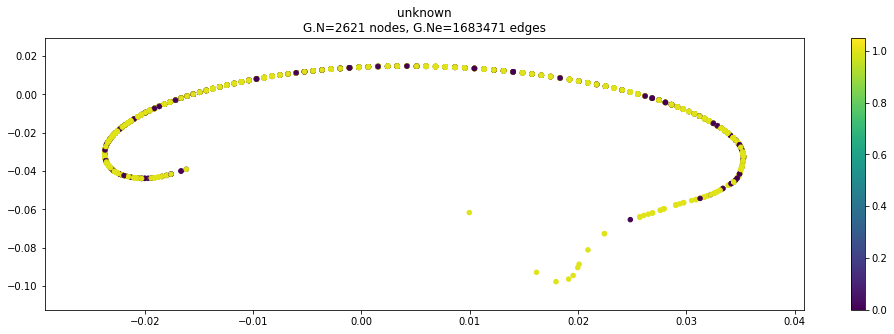

In [81]:
labels = preprocessing.LabelEncoder().fit_transform(df['success'])
G_act_ten.set_coordinates(G_act_ten.U[:,1:3])
G_act_ten.plot_signal(labels, vertex_size=20)

It can be seen on the plot above that the data are not well separated between sucess and failed movies.

In order to try improving the results, the matrix was sparsified by keeping only the 200 neighbors of each node that have the highest weights. This allows to keep at one the weights of pair of movies that are very similar. 

In [82]:
NormSparsActTenW = pd.read_csv('Saved_Datasets/DiffNorm75SparsActTenW.csv')
NormSparsActTenW = NormSparsActTenW.as_matrix()

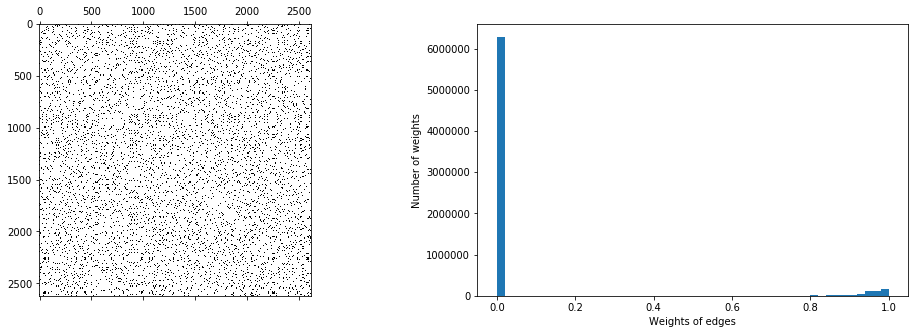

In [83]:
fix, axes = plt.subplots(1, 2)
axes[0].spy(NormSparsActTenW)
axes[1].hist(NormSparsActTenW.reshape(-1), bins=50);
axes[1].set_xlabel('Weights of edges')
axes[1].set_ylabel('Number of weights')

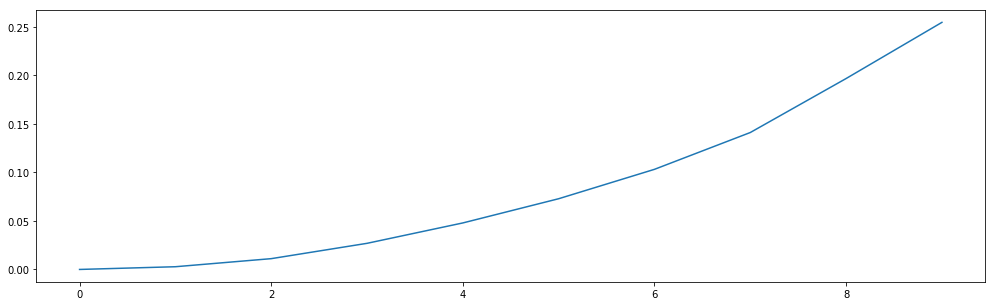

In [84]:
G_act_ten_spars = graphs.Graph(NormSparsActTenW)
G_act_ten_spars.compute_laplacian('normalized')
G_act_ten_spars.compute_fourier_basis(recompute=True)
plt.plot(G_act_ten_spars.e[0:10]);

By looking at the eigenvalues, it can be seen than when the weight matrix is sparsed the first eigenvalue doesn't describe the data well. 

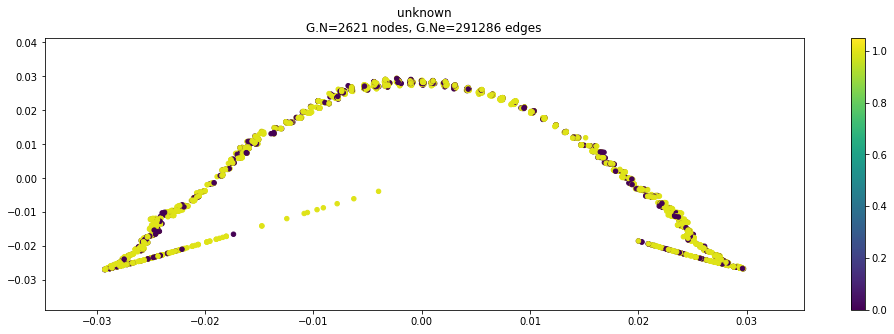

In [85]:
labels = preprocessing.LabelEncoder().fit_transform(df['success'])
G_act_ten_spars.set_coordinates(G_act_ten_spars.U[:,1:3])
G_act_ten_spars.plot_signal(labels, vertex_size=20)

It can be see, taht to sparse the weight matrix doesn't allow to better separate the data.

#### 3.3.3 Similarity between profitability of Actors ####

In this section, the goal was to study if the fact that actors present in a movie have played in movies which have generated a lot profit (revenue-budget) impacts the sucess of a movie. Numbers concerning how much profit actors have generated in their career are available on the website Box Office Mojo: http://www.boxofficemojo.com/people/. However, no API was available to collect the data, only webscrapping was possible. Since it would take too much time to collect these data, it was decided to compute the total actors profitability for each movie in the dataset by suming the profitability of each movie in the dataset, in which actors have played.
The profitability of each actor can be seen in the dataset Actors.

To compute the weight matrix the difference of the total actors profitability of each movie was computed between pairs of movies. Then the weight matrix was normalized as follows:
- $diff[i][j] = 0 : W[i][j] = 1$
- 0 < $diff[i][j] <= $ 3rd percentile of diff: $W[i][j] = 1- \frac{W[i][j]}{3rd \ percentile \ of \ diff}$
- $diff[i][j] > $ 3rd percentile of diff : $W[i][j]=0$

where the value of the 3rd percentil is 5037883028.0

*File too large to upload on moodle, see sparse matrix instead*

In [86]:
#DiffNormActProfW = pd.read_csv('Saved_Datasets/DiffNormActProfW.csv')
#DiffNormActProfW = DiffNormActProfW.as_matrix()

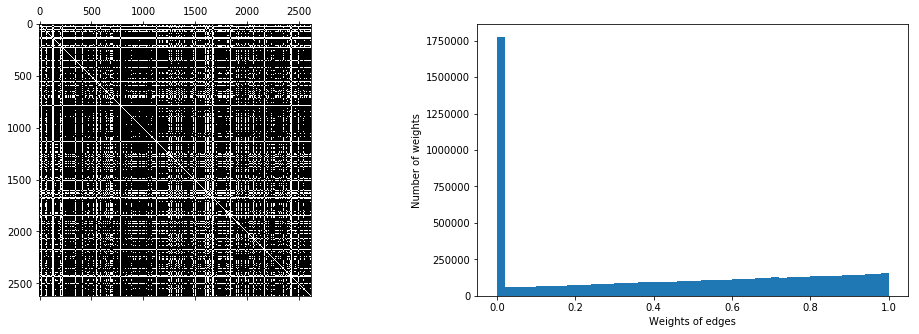

In [87]:
#fix, axes = plt.subplots(1, 2)
#axes[0].spy(DiffNormActProfW)
#axes[1].hist(DiffNormActProfW.reshape(-1), bins=50);
#axes[1].set_xlabel('Weights of edges')
#axes[1].set_ylabel('Number of weights')

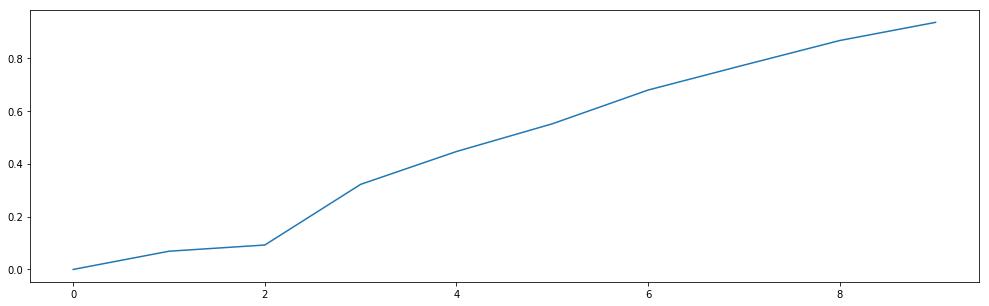

In [88]:
#G_act_prof = graphs.Graph(DiffNormActProfW)
#G_act_prof.compute_laplacian('normalized')
#G_act_prof.compute_fourier_basis(recompute=True)
#plt.plot(G_act_prof.e[0:10]);

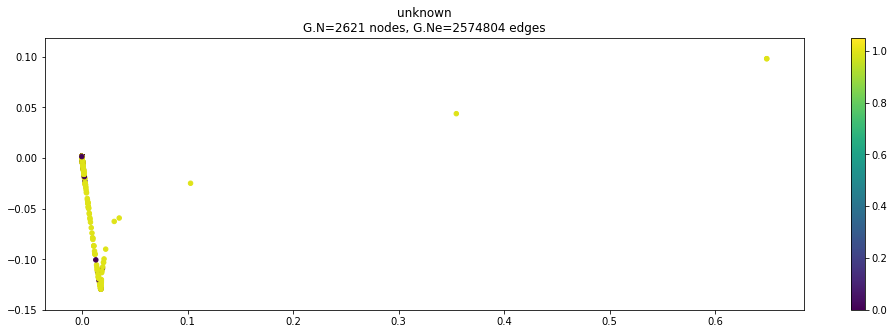

In [89]:
#labels = preprocessing.LabelEncoder().fit_transform(df['success'])
#G_act_prof.set_coordinates(G_act_prof.U[:,1:3])
#G_act_prof.plot_signal(labels, vertex_size=20)

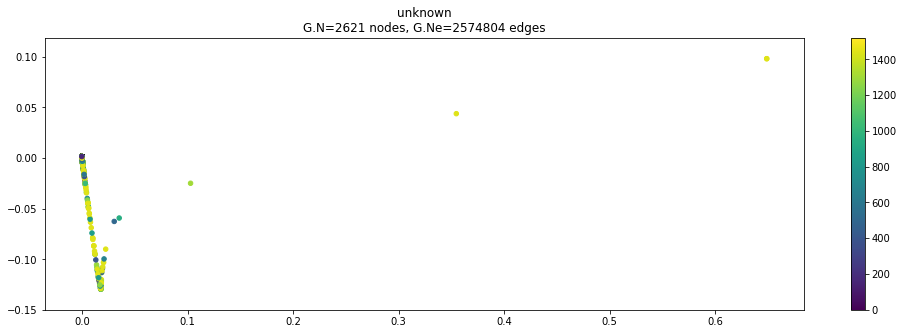

In [90]:
#labels = preprocessing.LabelEncoder().fit_transform(df['ROI'])
#G_act_prof.set_coordinates(G_act_prof.U[:,1:3])
#G_act_prof.plot_signal(labels, vertex_size=20)

In [91]:
NormActProfSparsW = pd.read_csv('Saved_Datasets/DiffNormActProfSparsW.csv')
NormActProfSparsW = NormActProfSparsW.as_matrix()

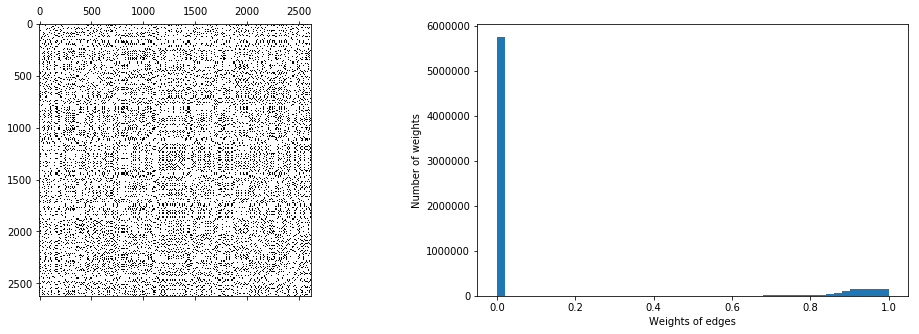

In [92]:
fix, axes = plt.subplots(1, 2)
axes[0].spy(NormActProfSparsW)
axes[1].hist(NormActProfSparsW.reshape(-1), bins=50);
axes[1].set_xlabel('Weights of edges')
axes[1].set_ylabel('Number of weights')

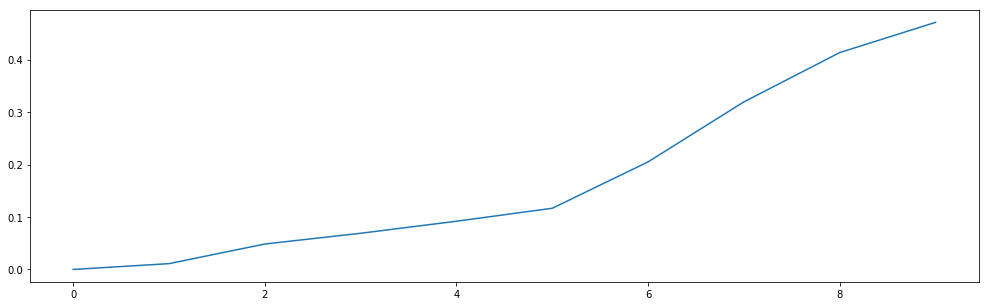

In [93]:
G_act_prof_s = graphs.Graph(NormActProfSparsW)
G_act_prof_s.compute_laplacian('normalized')
G_act_prof_s.compute_fourier_basis(recompute=True)
plt.plot(G_act_prof_s.e[0:10]);

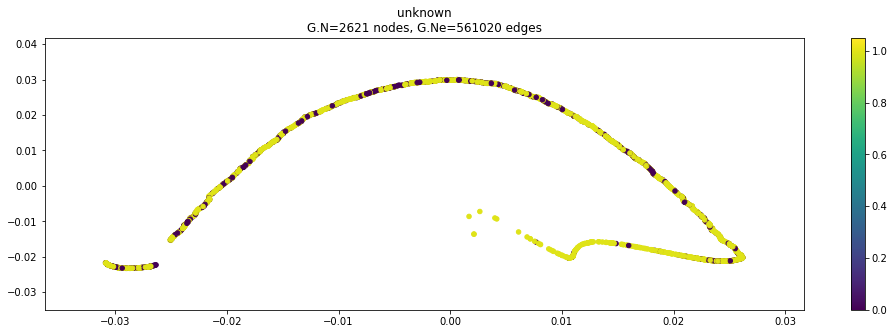

In [94]:
labels = preprocessing.LabelEncoder().fit_transform(df['success'])
G_act_prof_s.set_coordinates(G_act_prof_s.U[:,1:3])
G_act_prof_s.plot_signal(labels, vertex_size=20)

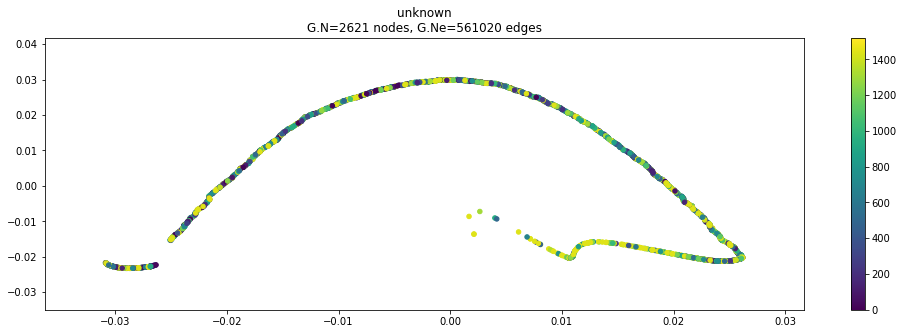

In [95]:
labels_reg = preprocessing.LabelEncoder().fit_transform(df['ROI'])
G_act_prof_s.plot_signal(labels_reg, vertex_size=20)

### 3.4 Directors in movies ###

#### 3.4.1 Similarties of directos between movies

In this section the directors in common between movies is studied. In fact, a lot of people come to see movies because the director of the movie is famous. The weight matrix was build by putting 1 on the edge of the graph if the two movies has the same director and 0 otherwise.

In [96]:
NormDicW = pd.read_csv('Saved_Datasets/NormalizedDirectorW.csv')
NormDicW  = NormDicW .as_matrix()

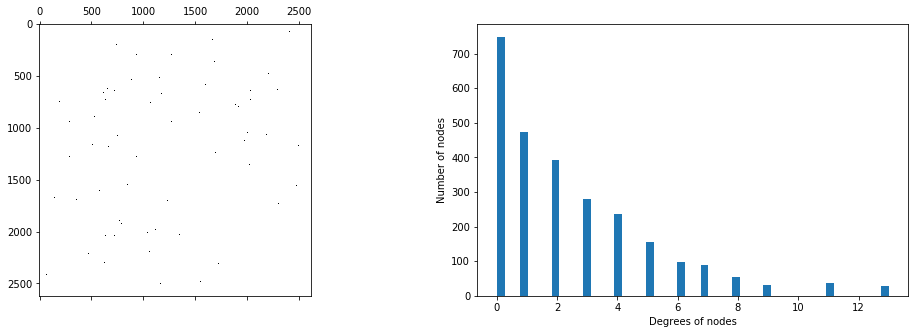

In [97]:
#Compute degree distribution 
degrees = np.zeros(len(NormDicW)) 
for i in range(0, len(NormDicW)):
    degrees[i] = sum(NormDicW[i])

fix, axes = plt.subplots(1, 2)
axes[0].spy(NormDicW)
axes[1].hist(degrees, bins=50);
axes[1].set_xlabel('Degrees of nodes')
axes[1].set_ylabel('Number of nodes')

As mentionned in Actors section with this type of simlarity graph, the laplacian matrix can not be computed because there is degrees equal to zero.

#### 3.4.2  Similarity between movies of the number of movies in the dataset produced by directors

An other type of similarity graph was built, by comparing between pairs of movies, the number of movies that directors have directed in our dataset. Even if this number of movies per director was computed with only the movies of our dataset, it is yet a good representation of which directors have experience. For real representation of the experience of director, data of all movies directed by all directors should have been collected.

A weight was given to each movies corresponding to the number of movies in dataset produced by the director of each movies. The weight matrix was build by computing the difference between the weight of each pair of movies. 

The weights matrix was then normalized as follows:
- $diff[i][j] = 0 : W[i][j] = 1$
- 0 < $diff[i][j] <= $ 3rd percentile of diff: $W[i][j] = 1- \frac{W[i][j]}{3rd \ percentile \ of \ diff}$
- $diff[i][j] > $ 3rd percentile of diff : $W[i][j]=0$



This gives the following normalized weight matrix:

In [98]:
DiffNormDirW = pd.read_csv('Saved_Datasets/DiffNormDirW.csv')
DiffNormDirW= DiffNormDirW.as_matrix()

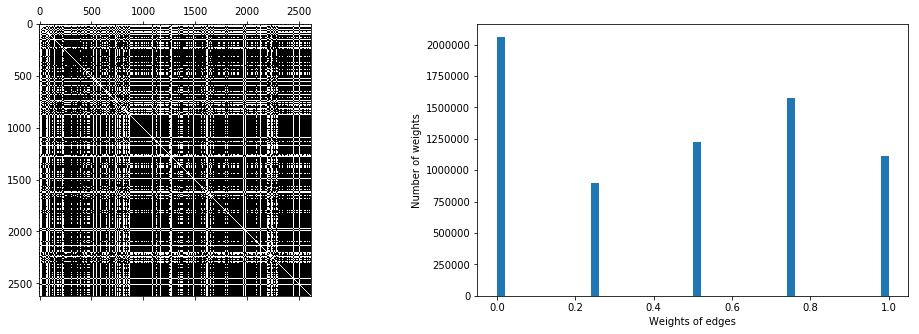

In [99]:
fix, axes = plt.subplots(1, 2)
axes[0].spy(DiffNormDirW)
axes[1].hist(DiffNormDirW.reshape(-1),bins=50);
axes[1].set_xlabel('Weights of edges')
axes[1].set_ylabel('Number of weights')

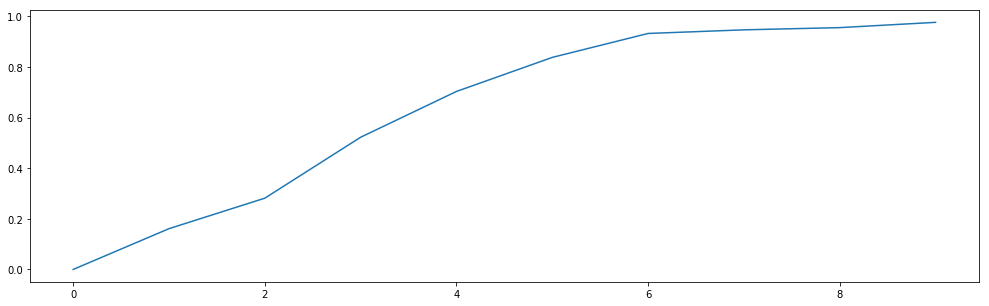

In [100]:
G_diff_dir = graphs.Graph(DiffNormDirW)
G_diff_dir .compute_laplacian('normalized')
G_diff_dir.compute_fourier_basis(recompute=True)
plt.plot(G_diff_dir.e[0:10]);

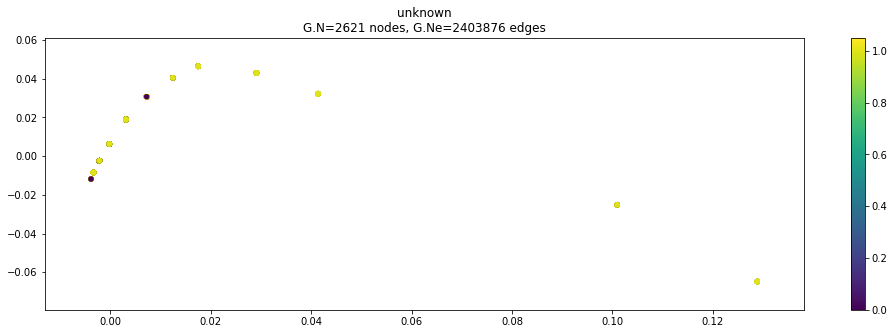

In [101]:
labels = preprocessing.LabelEncoder().fit_transform(df['success'])
G_diff_dir.set_coordinates(G_diff_dir.U[:,1:3])
G_diff_dir.plot_signal(labels, vertex_size=20)

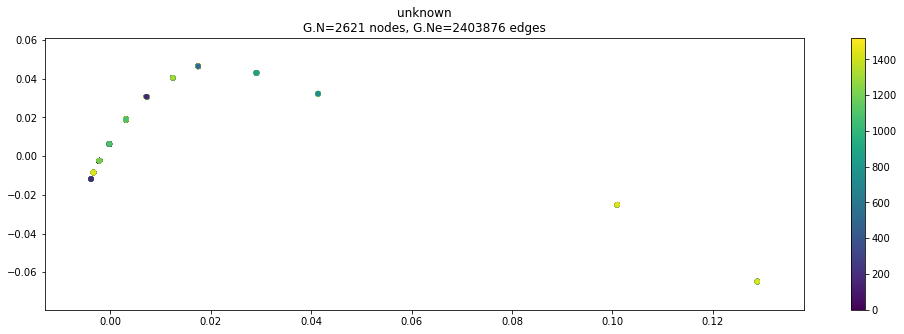

In [102]:
labels_reg = preprocessing.LabelEncoder().fit_transform(df['ROI'])
G_diff_dir.plot_signal(labels_reg, vertex_size=20)

The matrix is already well sparsified, so we didn't try do to it.

### 3.5 Production companies in movies ###

#### 3.5.1 Similarties of companies between movies ####

As for the actors and directors the companies in common between movies was studied. The weight matrix was build by putting 1 on the edge of the graph if the two movies were produced by the same company and 0 otherwise.

In [103]:
NormCompW = pd.read_csv('Saved_Datasets/NormalizedCompaniesW.csv')
NormCompW  = NormCompW.as_matrix()

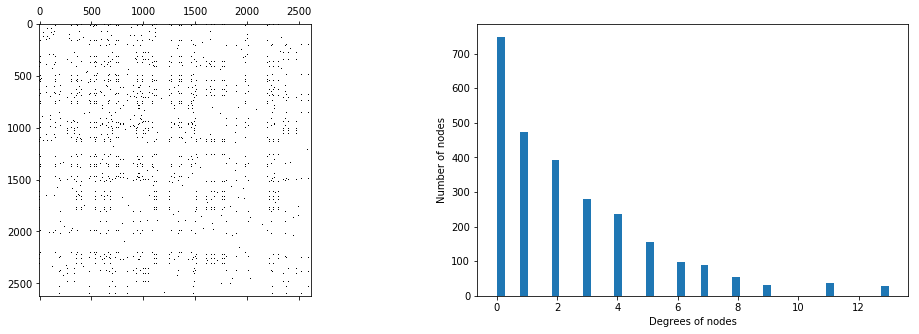

In [104]:
#Compute degree distribution 
degrees_comp = np.zeros(len(NormCompW)) 
for i in range(0, len(NormCompW)):
    degrees_comp[i] = sum(NormCompW[i])

fix, axes = plt.subplots(1, 2)
axes[0].spy(NormCompW)
axes[1].hist(degrees, bins=50);
axes[1].set_xlabel('Degrees of nodes')
axes[1].set_ylabel('Number of nodes')


As for the actors and directors it was observed that the company of some movies appears only in one movie which leads to unconnected movies (nodes) and the Laplacian of this weights matrix can't be computed.

#### 3.5.2 Difference of number of movies produced per companies between movies ####

As for the Directors, the number of movies that companies have produces in our dataset were compared between pairs of movies. As said in directors, section even if the number of movies produced per companies is computed with only the data from our dataset, it gives an idea of the distriubtion between movies.

First, a weight was given to each movies corresponding to the number of movies in dataset produced by the company of each movies. The weight matrix was build by computing the difference between the weight of each pair of movies. 

The weights matrix was then normalized as follows:
- $diff[i][j] = 0 : W[i][j] = 1$
- 0 < $diff[i][j] <= $ 3rd percentile of diff: $W[i][j] = 1- \frac{W[i][j]}{3rd \ percentile \ of \ diff}$
- $diff[i][j] > $ 3rd percentile of diff : $W[i][j]=0$

This gives the following normalized weight matrix:

In [105]:
DiffNormCompW = pd.read_csv('Saved_Datasets/DiffNormCompW.csv')
DiffNormCompW  = DiffNormCompW.as_matrix()

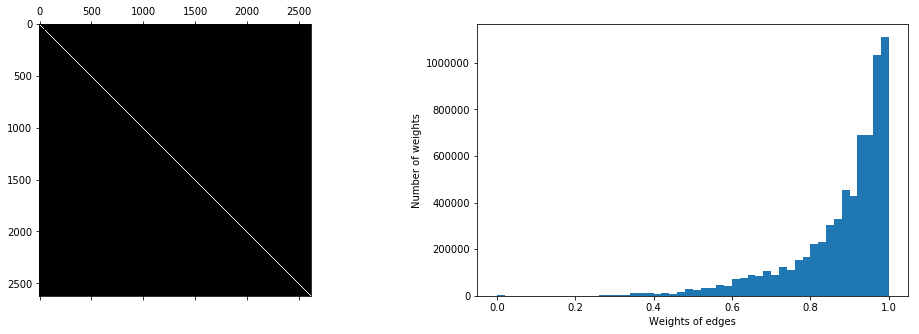

In [106]:
fix, axes = plt.subplots(1, 2)
axes[0].spy(DiffNormCompW)
axes[1].hist(DiffNormCompW.reshape(-1),bins=50);
axes[1].set_xlabel('Weights of edges')
axes[1].set_ylabel('Number of weights')

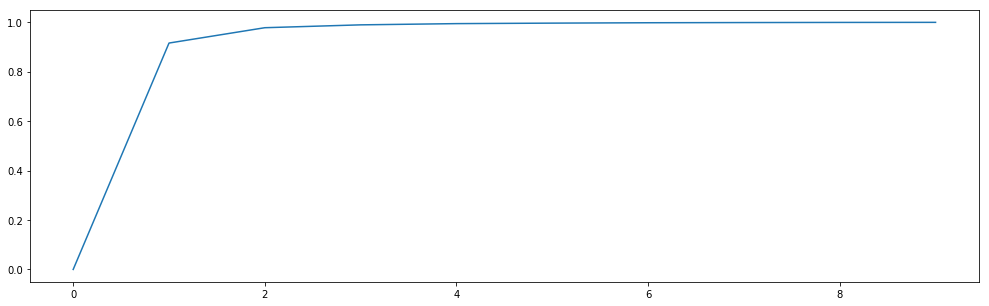

In [107]:
G_diff_comp = graphs.Graph(DiffNormCompW)
G_diff_comp .compute_laplacian('normalized')
G_diff_comp.compute_fourier_basis(recompute=True)
plt.plot(G_diff_comp.e[0:10]);

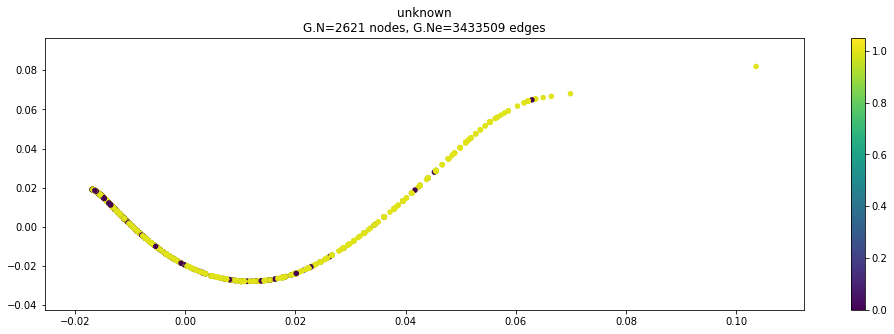

In [108]:
labels = preprocessing.LabelEncoder().fit_transform(df['success'])
G_diff_comp.set_coordinates(G_diff_comp.U[:,1:3])
G_diff_comp.plot_signal(labels, vertex_size=20)

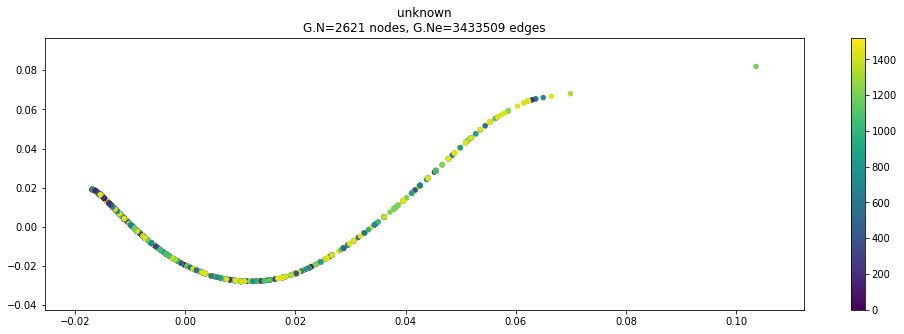

In [109]:
labels_reg = preprocessing.LabelEncoder().fit_transform(df['ROI']/2.64)
G_diff_comp.plot_signal(labels_reg, vertex_size=20)

### 3.6. Storyline ### 

In this section, we are interested in knowing how much the story seems to impact of the success and ROI of a movie. To do this, we first had to determine how similar movies were based on their overview.

#### 3.6.1 Similarity graph ####

A similarity graph between movies was created based on storylines of each movies. This was done by first determining the words amongst the 100 previously determined most common words each storyline contained to avoid comparing strange characters or familiar words that were not removed from the procedures desribed previously. The similarity between each pairs of films was then computed based on whether they contained the same most common words.

$$W_{ij} = Number \ of \ similar \ common \ words \ between \ i \ and \ j$$

$\textbf{For example, with films i and j:}$

* List of words amongst 100 most common for film i = ['life', 'love', 'death']

* List of words amongst 100 most common for film j = ['love', 'death', 'assassin', 'kill']

* Number of similar common words between i and j = 2

$$W_{ij} = 2 $$


In terms of normalization, we initially tried to do this similarly to the first method shown in section 3.1 for the genres:

$$W_{ij} = \frac{Number \ of \ similar \ common \ words \ between \ i \ and \ j}{Highest \ number \ of \ common \ words \ between \ i \ and \ j}  \in [0; 1]$$

such that in the example shown above:

* Highest number of common words between i and j = 4

$$W_{ij} = 0.5 $$


However, this penalizes a pair of films for having many words amongst the list of 100 even if they have many of them in common. 

As such, we decided to observe the distribution of the number of similar common words between pairs of films. From the distribution, we observed that the greatest number of similar words is 8. However the average number of similar words is 0.24 and the 75th percentile is at zero. This would mean that already having 1 similar word in common is relatively rare. 

We therefore decided to apply a binary weight as defined below:

$$ W_{ij} = \begin{cases}0, & Nb \ of \ similar \ common \ words \ between \ i \ and \ j =0 \\ 1, & Nb \ of \ similar \ common \ words \ between \ i \ and \ j \geq 1 \end{cases}$$

In [110]:
NormTextW = pd.read_csv('Saved_Datasets/TextWSparsePerc.csv')

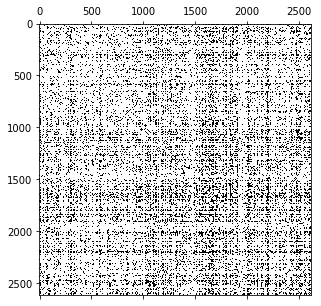

In [111]:
plt.spy(NormTextW)

#### 3.6.2. Graph Laplacian ####

Computation of the normalized Laplacian of the graph.

In [112]:
GText = graphs.Graph(NormTextW)
GText.compute_laplacian('normalized')

#### 3.6.3. Graph embedding: Laplacian eigenmaps ####


Display of the Laplacian's eigenmaps

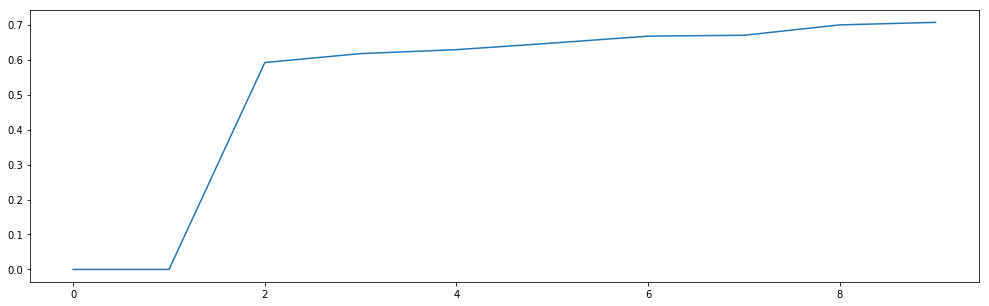

In [113]:
GText.compute_fourier_basis(recompute=True)
plt.plot(GText.e[0:10]);

From this plot, we can see that in addition to the first eigenvalue, the second eigenvalue seems to be zero which would indicate the presence of two giant components! Let us now observe the actual value of the second eigenvalue:

In [114]:
print('The value of the 1st eigenvalue is: {}'.format(GText.e[1]))

The value of the 1st eigenvalue is: 1.4430679104324977e-15


We then embed the data on the second and third eigenvectors.

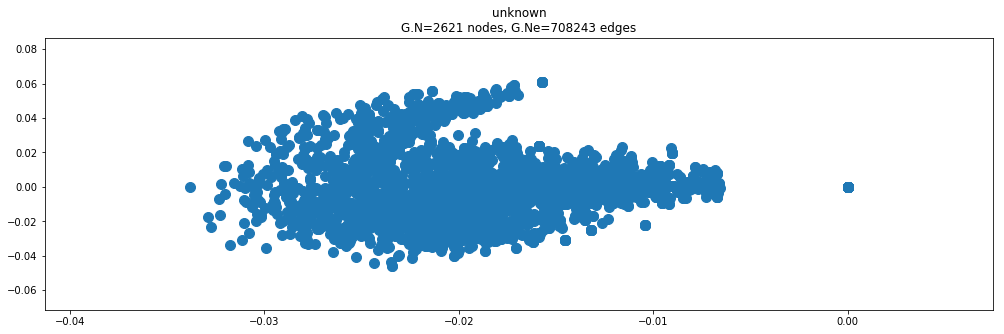

In [115]:
GText.set_coordinates(GText.U[:, 1:3])
GText.plot()

##### 3.6.3.1. Classification #####

We then assign a signal to our datapoints according to the notion of success defined previously with the ROI to observe whether the data would potentially be separable along one or both of the eigenvectors.  

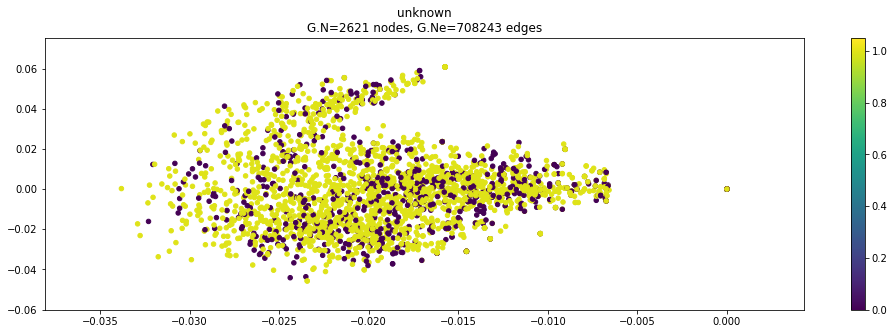

In [116]:
GText.plot_signal(genres, vertex_size=20)

From this plot, we can observe that there does not seem to be separable into the two desired classes. Indeed, movies with the same features seem to have both successful and un-successful labels.

##### 3.6.3.2. Regression #####

In this case we directly assign the ROI of the movie as label for each datapoint to observe whether movies with similar text words generated the same values of ROI. 

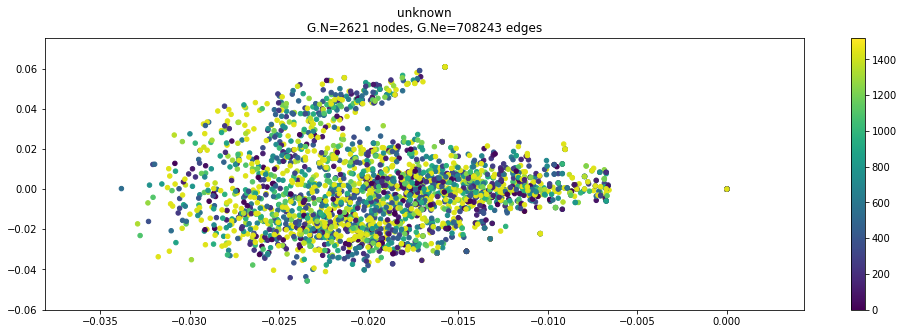

In [117]:
labels_reg = preprocessing.LabelEncoder().fit_transform(df['ROI']/2.64)
GText.plot_signal(labels_reg, vertex_size=20)

Similarly to the classification case of the previous subsection, we notice that the similar movies in terms of storyline do not necessarily generate the same values of ROI.

### 3.7 Metacritic of movies

In [118]:
DiffMetaW = pd.read_csv('Saved_Datasets/NormalizedMetacriticW.csv')
DiffMetaW = DiffMetaW.as_matrix()

#### 3.7.1 Similarity Graph

We then created a similarity weight matrix between movies, where we ignored the movies with a metacritic rating equal to zero. We simply took the difference of ratings between two movies.

$$ W(i,j) = \begin{cases}
0 & \text{if } Metacritic(i,j) = 0\\
\frac{1-\|Metacritic(i) - Metacritic(j)\|}{100} & \text{otherwise} \end{cases}$$

With this following formula, the weights are between 0 (opposed ratings) and 1 (same ratings).

As this is a Gaussian distribution, a lot of movies have similar ratings :

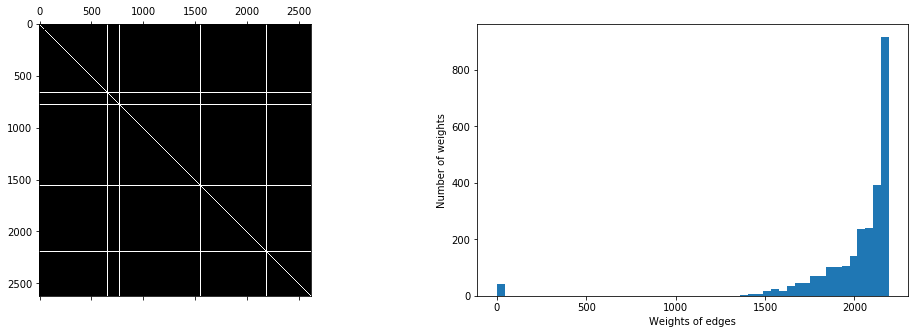

In [119]:
#Compute degree distribution 
degrees = np.zeros(len(DiffMetaW)) 
for i in range(0, len(DiffMetaW)):
    degrees[i] = sum(DiffMetaW[i])

fix, axes = plt.subplots(1, 2)
axes[0].spy(DiffMetaW)
axes[1].hist(degrees.reshape(-1),bins=50);
axes[1].set_xlabel('Weights of edges');
axes[1].set_ylabel('Number of weights');

As we can see in the figure above, the weight matrix contains some zeros. Hence, it is impossible to compute the Laplacian directly. We must wait to include this weights in the total weight matrix.

### 3.8 YouTube Trailers Analysis

As we have a different dataset for the Trailer views (because of the missing data), we tried to see if we could explain the success of a movie only with the help of the trailer views. The similarity matrix is simply the difference between two normalized view counts.

In [120]:
DiffTrailerW = pd.read_csv('Saved_Datasets/NormalizedTrailerW.csv')
DiffTrailerW = DiffTrailerW.as_matrix()

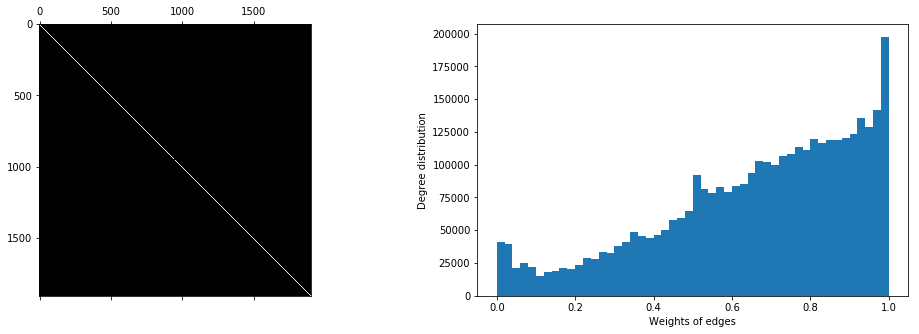

In [121]:
#Compute degree distribution 
fix, axes = plt.subplots(1, 2)
axes[0].spy(DiffTrailerW)
axes[1].hist(DiffTrailerW.reshape(-1),bins=50);
axes[1].set_xlabel('Weights of edges');
axes[1].set_ylabel('Degree distribution');

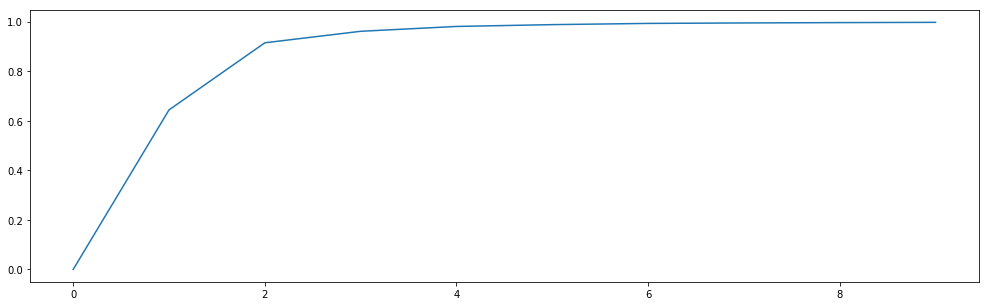

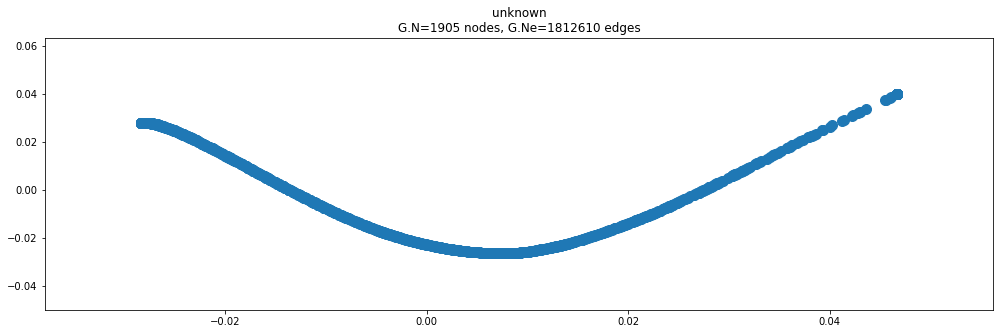

In [122]:
G = graphs.Graph(DiffTrailerW)
G.compute_laplacian('normalized')
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

G.set_coordinates(G.U[:, 1:3])
G.plot()

In [123]:
df_noerror = df.drop(df[df['YouTube_Mean'] == 'Error'].index)
labels = preprocessing.LabelEncoder().fit_transform(df_noerror['success'])
G.set_coordinates(G.U[:,1:3])

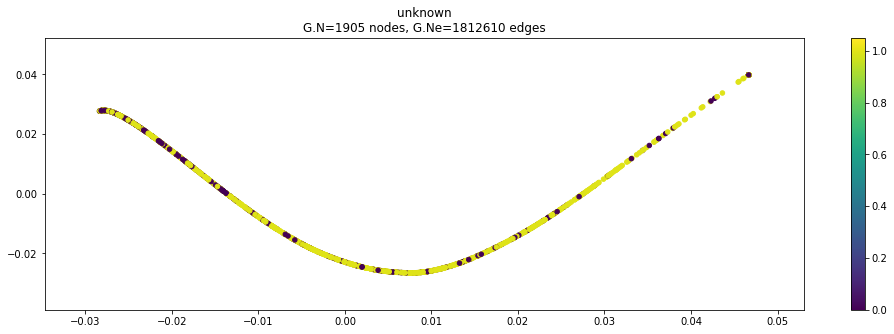

In [124]:
G.plot_signal(labels, vertex_size=20)

### 3.9. Combination of the weight matrices ### 

In this section, we will study the combination of all the weight matrices from above. As their values are already normalized between 0 and 1, we can simply add all of them and divide the result by the number of weight matrices:

$$ W_{Tot} = \frac{1}{N}\sum_{i=1}^{N} W_i $$

where $N$ is the number of retained weight matrices and $W_{i}$ is one of the weight matrices computed above.  

$\underline{\textbf{Note:}}$ Only some of the weight matrices were kept (for example those sparsed and those with the appropriate normalization)   

In [125]:
WTot = NormActProfSparsW + DiffSparsBudgW + GenreW.as_matrix(columns=None) + NormSparsActTenW + DiffNormDirW + DiffNormCompW + NormTextW.as_matrix(columns=None)
WTot = WTot/7

We can then plot the weighted matrix to observe its connectivity as well as the weight and degree distribution.

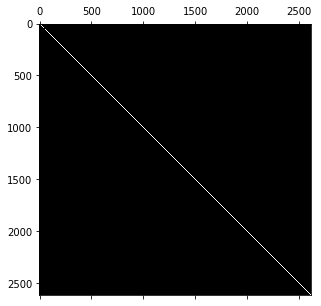

In [126]:
plt.spy(WTot)

The mean value is: 0.29468697781783304
The max value is: 0.9839849056236751
The min value is: 0.0


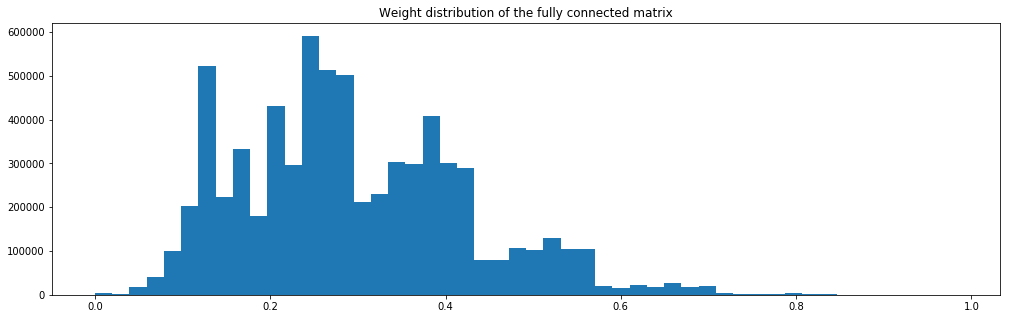

In [127]:
plt.hist(WTot.reshape(-1), bins=50);
plt.title('Weight distribution of the fully connected matrix');
print('The mean value is: {}'.format(WTot.mean()))
print('The max value is: {}'.format(WTot.max()))
print('The min value is: {}'.format(WTot.min()))

The mean value is: 772.3745688605394
The max value is: 1013.7666635191015
The min value is: 353.75875513882113


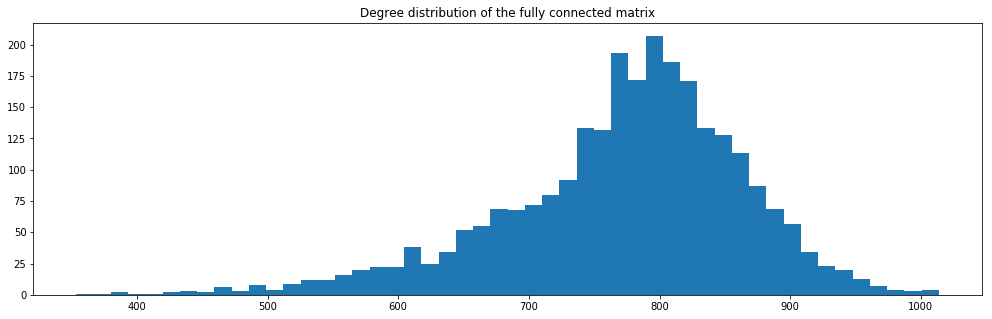

In [128]:
degrees = np.zeros(len(WTot)) 

#reminder: the degrees of a node for a weighted graph are the sum of its weights

for i in range(0, len(WTot)):
    degrees[i] = sum(WTot[i])

plt.hist(degrees, bins=50);
plt.title('Degree distribution of the fully connected matrix');
print('The mean value is: {}'.format(degrees.mean()))
print('The max value is: {}'.format(degrees.max()))
print('The min value is: {}'.format(degrees.min()))

#### 3.8.1 Fully connected matrix #### 

In this section, we want to try and perform graph embedding with Laplacian eigenmaps using the full weight matrix $W_{Tot}$ explained above.

Let us first compute the normalized Laplacian of the graph and its eigenvalues:

In [129]:
G = graphs.Graph(WTot)
G.compute_laplacian('normalized')

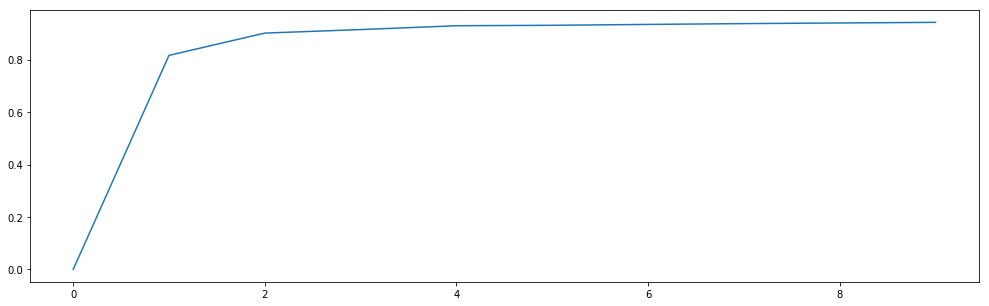

In [130]:
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

From this plot, we observe that it would seem that the second and third eigenvalues seem to explain most of the variability of the data. 

Let us now embed the data along their respective eigenvectors.

##### 3.8.1.1. Classification ##### 

In this case, the graph is embedded on the first two eigenvectors with the labels of 'successful' (1) or 'unsuccessful' (0). 

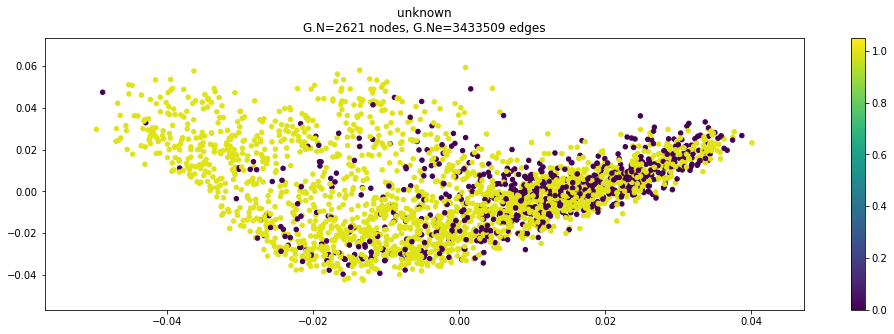

In [131]:
G.set_coordinates(G.U[:,1:3])
G.plot_signal(genres, vertex_size=20)

From this plot, we observe that despite a tendency to have more "successful" movies for negative values along the 2nd eigenvector (x-axis), the data does not appear to be separable as a lot of "successful" and "unsuccessful" movies seem to be regrouped together on the right side of the plot. 

##### 3.8.1.2. Regression ##### 

In this second case, the graph is embedded on the first two eigenvectors with the their signals being the ROI.

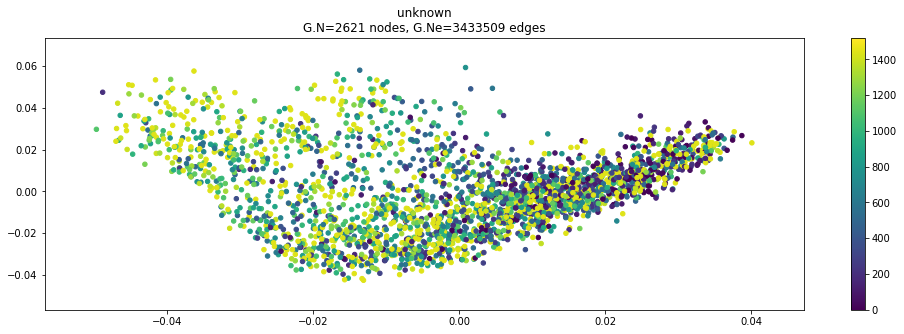

In [132]:
G.plot_signal(labels_reg, vertex_size=20)

We observe that there is no gradient of the signal along any axis such that we are unable to predict the ROI of a movie based solely on the features used to construct our graph.

#### 3.8.2 Sparsed matrix #### 

In order to potentially be able to better separate our data, it was decided to sparse the obtained weight matrix such that similar movies would be more easily regrouped together.

In [133]:
NEIGHBORS = 300

#sort the order of the weights
sort_order = np.argsort(WTot, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(WTot), len(WTot)))

for i in range (0, len(WTot)):  
    for j in range(0, len(WTot)):
        if (j >= len(WTot) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = WTot[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

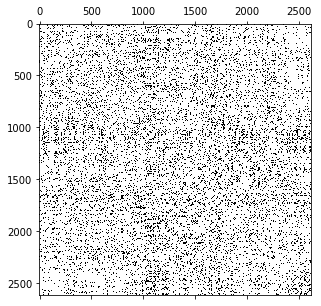

In [134]:
WTot = sorted_weights
plt.spy(WTot)

The mean value of the weight matrix is: 0.07263556640555706
The max value of the weight matrix is: 0.9839849056236751
The min value of the weight matrix is: 0.0


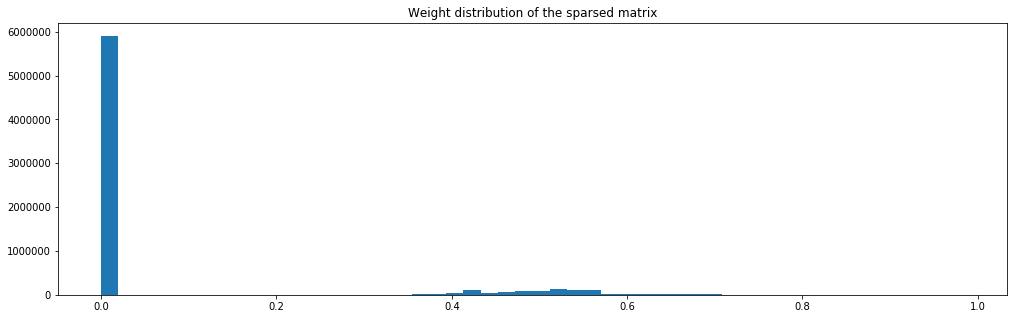

In [135]:
plt.hist(WTot.reshape(-1), bins=50);
plt.title('Weight distribution of the sparsed matrix');
print('The mean value of the weight matrix is: {}'.format(WTot.mean()))
print('The max value of the weight matrix is: {}'.format(WTot.max()))
print('The min value of the weight matrix is: {}'.format(WTot.min()))

The mean value is: 190.37781954896502
The max value is: 443.81372297024495
The min value is: 108.4502931268722


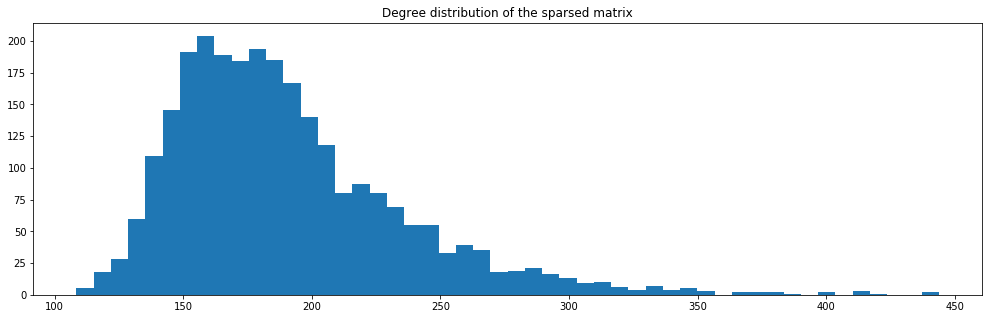

In [136]:
degrees = np.zeros(len(WTot)) 

#reminder: the degrees of a node for a weighted graph are the sum of its weights

for i in range(0, len(WTot)):
    degrees[i] = sum(WTot[i])

plt.hist(degrees, bins=50);
plt.title('Degree distribution of the sparsed matrix');
print('The mean value is: {}'.format(degrees.mean()))
print('The max value is: {}'.format(degrees.max()))
print('The min value is: {}'.format(degrees.min()))

In [137]:
G = graphs.Graph(WTot)
G.compute_laplacian('normalized')

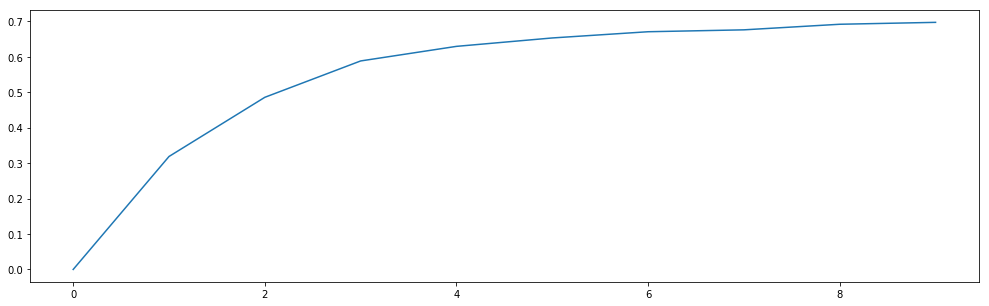

In [138]:
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

##### 3.8.2.1. Classification ##### 

In this case, the graph is embedded on the first two eigenvectors with the labels of 'successful' (1) or 'unsuccessful' (0). 

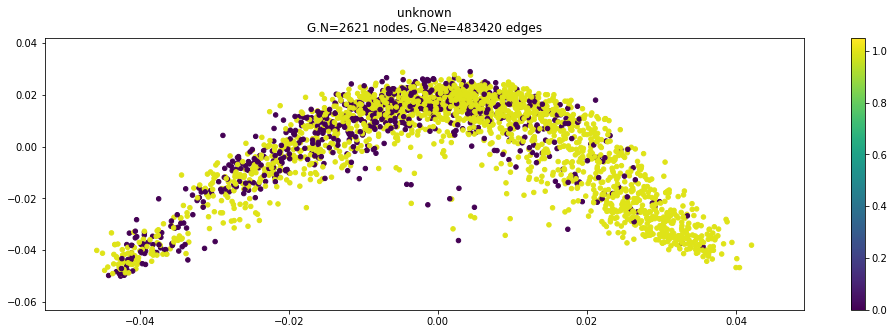

In [139]:
G.set_coordinates(G.U[:, 1:3])
G.plot_signal(genres, vertex_size=20)

##### 3.8.2.2. Regression ##### 

In this second case, the graph is embedded on the first two eigenvectors with the their signals being the ROI.

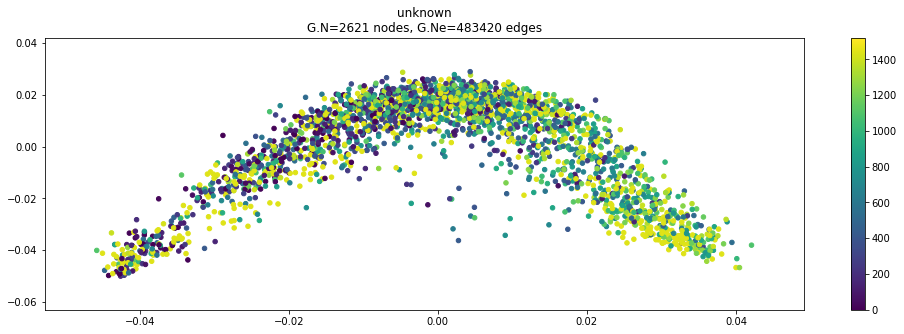

In [140]:
labels_reg = preprocessing.LabelEncoder().fit_transform(df['ROI']/2.64)
G.plot_signal(labels_reg, vertex_size=20)

Similarly to the case of the unsparsified graph, the plot shown above indicates that we are unable to predict the ROI of a movie based solely on these features.

## 4. Discussion ##

The results obtained above suggest that none of the features observed seem to directly impact the success of a movie. Indeed, the data did not seem to be separable during our embedding with Laplacian eigenmaps on any of the obtained graphs. However, this is not necessarily representative of reality as only a certain number of movies were collected and used due to either missing or strange values in our dataset. Indeed, ideally it would be necessary to obtain data about all the english movies for both our data exploration and exploitation to be representative of reality. 

Furthermore, the dataset also sometimes contained different actors and movies with the same names thus impacting our results due to the way the data is treated and it was also noticed that some of the data featured on TMBd was not in agreement with the values on IMDB.  

Multiple aspects of our project could therefore be improved to potentially better understand what impacts the success of a movie.

### 4.1. Possible improvements ###

To further improve this project, multiple factors in our analysis could be revised, such as more work on the text analysis and the collection of additional data outside of our dataset. Indeed, to fully analyse the text and observe whether two storylines are similar, it would be necessary to consider both the synonyms and antonyms of each word of the storyline when comparing it with that of another film such that we could get a better notion of similarity or dissimilarity. Additionally, lemmatization and stemming could be done since it could impact the computation of the most frequent words. 

It should also be noted that most of our data comes from the dataset collected from kaggle. As such, it might have been potentially more wise to correct our data (if necessary) with the help of other sources and/or collect more data from other websites such that more features or movies could be obtained. 

Furthermore, additional factors could potentially impact the success of a movie and could somehow be taken into account, such as the trends of the year during which the film was made, the effectiveness of its publicity, as well as the economy and events that could have happened throughout that year.

### 4.2. Additional encountered problems ###

Aside from the possible improvements and problems discussed above, other problems were encountered which disabled us from further exploiting the data. Indeed, as mentionned above, an attempt was made to observe whether the sucess of a film was due to a "network effect", i.e. the publicity that a film generates before its release. This was done by collecting the number of views a trailer of a certain movie had on YouTube. However, for this to be unbiased, the data should only be collected from one or all YouTube channels that publish trailers. The problem was that no YouTube channel seemed to contain all the trailers of the movies contained in our dataset. 

A certain weight could potentially have been given based on the number of subscribers for each channel such that the number of views of the trailers of all of the movies our dataset could have been taken into account in our analysis, however the number of subscribers is not necessarily representative of the number of people who follow a channel but are not necessarily subscribed.

Due to lack of time, this subject was not elaborated further.

## 5. Conclusion ##

In this project, the influence of each of the features was studied to try and determine their impact on and contribution to the success. This was done by first defining the notion of success for movies and observing the similarities between movies for each of the obtained features.

The obtained results would seem to indicate the inability to predict the success of a movie based purely on the features of a movie such as its cast, storyline, budget, production company, etc. However, as discussed previously, this could be due to the size of our dataset as not all movies are considered during our analysis such that our dataset might not be sufficiently representative of reality. Furthermore, certain aspects could potentially highly impact the success of a movie such as the trends, economy and effectiveness of the publicity through media. However, due to lack of time, these aspects could not further be elaborated. 


## 6. References ##

1) http://ew.com/movies/2017/09/04/summer-box-office-fail/

2) http://www.imdb.com/

3) https://www.kaggle.com/rounakbanik/the-movies-dataset/

4) https://www.themoviedb.org/?language=en

5) Bird, Steven, Edward Loper and Ewan Klein (2009), "Natural Language Processing with Python". O’Reilly Media Inc. (http://www.nltk.org/#natural-language-toolkit)